In [85]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import calendar
from sklearn.linear_model import LinearRegression
import json
import seaborn as sns
from math import floor
from scipy.stats import ttest_ind

# Disable new warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Beyond Originals: A Deep Dive into Sequel Success

In this project, our focus is on movies and their sequels, as well as movies without sequels. The initial step involves data preprocessing to facilitate subsequent analysis.

## Data collection

To actually carry out our project idea, we needed to obtain one extra information, which is not given in our initial dataset: _does a movie have a sequel?_

We extracted the missing information regarding movie sequels by web scraping from Wikipedia and Wikidata. Indeed, Wikidata has a specific section dedicated to this, as can be seen in the image here-under. 

<div>
<img src="./sequel_scraper/wikidata_sequel_info.png" width="700"/>
</div>



The code used for this is in the file "wiki_scraper.py" which can be found under ./sequel_scraper. 

Here's a recap of the what the code does:

Data Loading:
The code starts by importing necessary libraries, such as pandas for data manipulation, requests for making HTTP requests, and BeautifulSoup for web scraping.
The movie metadata is loaded from a TSV file into a Pandas DataFrame. 

Two functions are defined for web scraping:
extract_ID: Extracts the Wikidata ID from a given string.
scrape_wikidata_id: Scrapes the Wikidata ID for a given movie from its Wikipedia page.
scrape_sequels: Scrapes the prequel and sequel IDs for a given movie from its Wikidata page.

Scraping Loop:
A new Pandas DataFrame named online_scraping is created with columns 'WikipediaID', 'WikidataID', 'PrequelID', and 'SequelID' to store the scraping results.
A loop iterates over the dataframe, calling the scrape_wikidata_id and scrape_sequels functions to extract Wikidata and sequel information for each movie.
The results are stored in the online_scraping DataFrame.

Output:
The scraping results are saved to a CSV file named 'sequels.csv'. The CSV file includes columns for WikipediaID, WikidataID, PrequelID, and SequelID.


## Some initial dataframes

For reference, here are the naming conventions used:
- An _original_ movie is a movie that has a sequel

The file *sequels.csv* contains 4 columns : 
- WikipediaID : ID from wikipedia
- WikidataID : ID from wikidata
- PrequelID : ID of the prequel from wikidata (nan when there is no prequel) 
- SequelID : ID of the sequel from wikidata (nan when there is no sequel) 

In [86]:
from_csv = pd.read_csv("sequels.csv")
originals_sequels = from_csv[['WikipediaID', 'WikidataID', 'SequelID']].dropna(subset=['SequelID']) #We only keep the movies with a sequel

In [87]:
#Now we need to only keep original films that are in the CMU dataset
cmu_movies = pd.read_csv("movie_summaries/movie.metadata.tsv", sep="\t", names = ['WikipediaID', 'FreebaseID', 'MovieName', 'ReleaseDate', 'BoxOffice', 'Runtime', 'Languages', 'Countries', 'Genres'])

 Before moving on to the next phase, we encountered some errors while exploring the data. Since these errors are not frequent, we have opted to address them manually and make the necessary updates.

### Error corrections

**Zero Tolerance** has a runtime of 1079281 minutes which is false when looking up on the [wikipedia page](https://en.wikipedia.org/wiki/Zero_Tolerance_(1994_film)), the true value is 94 minutes. 

**Hunting Season** has 1010 as the released year, which is also a mistake when looking at the [wikipedia page](https://en.wikipedia.org/wiki/Hunting_Season_(2010_film)), the true year of released is 2010. 

In [88]:
cmu_movies.at[12804,'Runtime'] = 94.0 # Fixing runtime for Zero Tolerance
cmu_movies.at[62836,'ReleaseDate'] = '2010-12-02' # Fixing date for Hunting Season

In [89]:
df_has_sequels = cmu_movies[cmu_movies['WikipediaID'].isin(originals_sequels['WikipediaID'])] #Dataframe with only movies that have a sequel
df_no_sequels = cmu_movies[~cmu_movies['WikipediaID'].isin(originals_sequels['WikipediaID'])] #Dataframe with only movies that don't have a sequel

In [90]:
percentage_with_sequels = len(df_has_sequels)/len(cmu_movies)
print(f'Percentage of films with a sequel : {percentage_with_sequels:.2f}')

Percentage of films with a sequel : 0.05


So, only about 5% of movies have a sequel, which isn't much in our dataset. Our objective is to comprehend the distinctions among this subset of films, those without a sequel, and compare them against the overall dataset statistics.



## Part 1: Comparing movies with sequels and movies with no sequels

We will begin by doing some initial comparaison on : 
* Earnings
* Duration
* Month of release
* Year of release
* Country of origin
* Film genre
* Characters
    * Age
    * Gender

### Earnings

Our initial approach involves creating a plot to compare the revenues of movies with sequels to those without sequels. This graphical representation will serve as an initial exploration into the potential differences in revenue between these two categories.

In [91]:
with_sequels_earnings = df_has_sequels.dropna(subset=['BoxOffice'])
no_sequels_earnings = df_no_sequels.dropna(subset=['BoxOffice'])

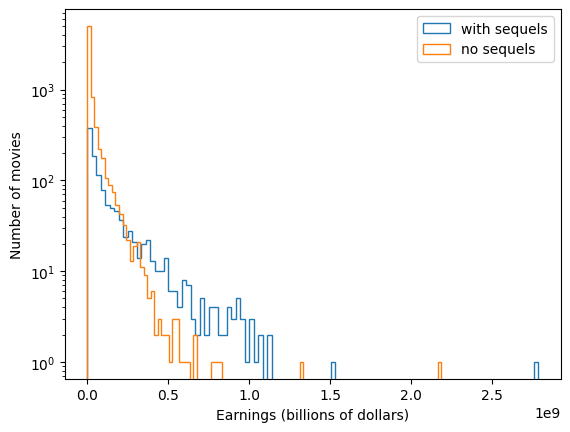

In [92]:
# Plot the earnings of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.

n_bins = 100
plt.hist(with_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Earnings (billions of dollars)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

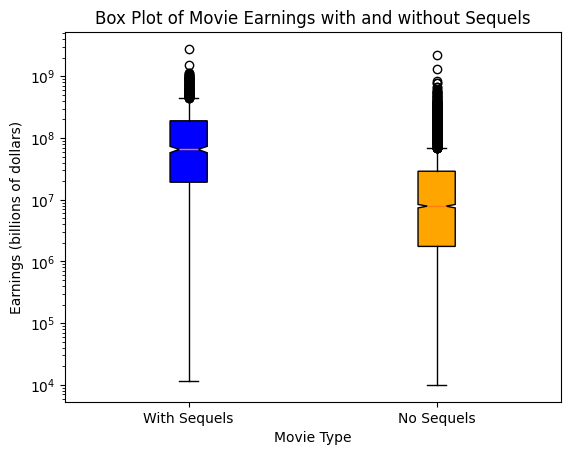

In [93]:
# For better vizualisation, we plot the Box Plot of earnings of movies with sequels and those without sequels

# Combine the earnings data into a list for box plot creation
earnings_data = [with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice']]

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Earnings (billions of dollars)')
plt.title('Box Plot of Movie Earnings with and without Sequels')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(earnings_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()


At quick glance, it seems like movies with sequels rake in more money than those without. But hold on, a bunch of the data is missing!

In [94]:
print(f'Percentage of movies with sequels that has the revenue in the dataset : {len(with_sequels_earnings)/ len(df_has_sequels):.2f}')
print(f'Percentage of movies with no sequels that has the revenue in the dataset : {len(no_sequels_earnings)/ len(df_no_sequels):.2f}')

Percentage of movies with sequels that has the revenue in the dataset : 0.31
Percentage of movies with no sequels that has the revenue in the dataset : 0.09


Only 31% and 9% of the data repespectively is present. We need a deeper analysis to confirm that movies with sequels are movies that tend to generate more money.

In [95]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(with_sequels_earnings['BoxOffice'], no_sequels_earnings['BoxOffice'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in earnings between movies with sequels and without sequels.')


T-test Statistic: 18.76842645919925
P-value: 2.1795476437484413e-69
Reject the null hypothesis: There is a significant difference in earnings between movies with sequels and without sequels.


### Duration 

In [96]:
with_sequels_duration = df_has_sequels.dropna(subset=['Runtime'])
no_sequels_duration = df_no_sequels.dropna(subset=['Runtime'])

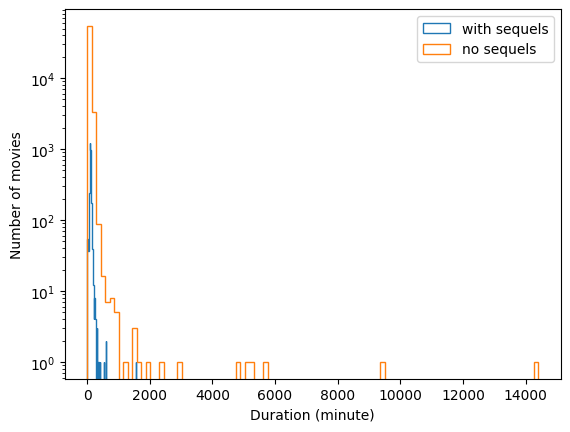

In [97]:
# Plot the duration of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.

n_bins = 100
plt.hist(with_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

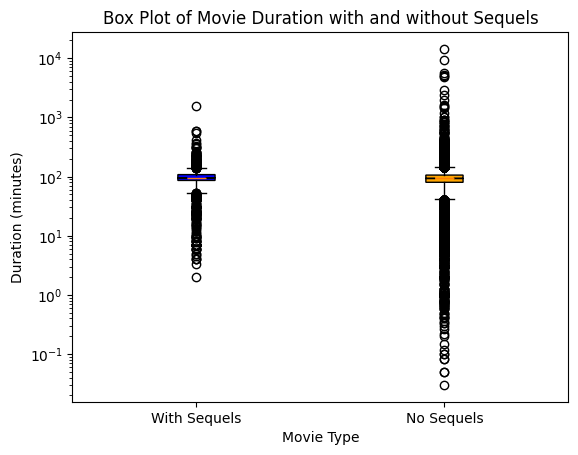

In [98]:
# Combine the duration data into a list for box plot creation
duration_data = [with_sequels_duration['Runtime'], no_sequels_duration['Runtime']]

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()


Let's look at the data for both categories more closely and get some numbers.

In [99]:
no_sequels_duration['Runtime'].describe()

count    57865.000000
mean        93.962255
std         93.391836
min          0.000000
25%         80.000000
50%         93.000000
75%        106.000000
max      14400.000000
Name: Runtime, dtype: float64

In [100]:
with_sequels_duration['Runtime'].describe()

count    3426.000000
mean       98.422834
std        42.194757
min         2.000000
25%        86.000000
50%        95.000000
75%       108.000000
max      1560.000000
Name: Runtime, dtype: float64

We have identified outliers in our data, which contains both very long and very short movies. Upon further investigation, we've uncovered a new category of movies that wasn't initially considered. Let's see what our longest movie is.

In [101]:
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].max()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
62962,32441022,/m/0gyr803,Modern Times Forever,NaN,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}"


In our investigation of this movie, we came across this [wikipedia page](https://en.wikipedia.org/wiki/List_of_longest_films), specifically dedicated to the longest films. However, this category poses challenges for standard plotting. Additionally, it's worth noting that certain entries, like Swallow the Sun, may not fit the conventional definition of a movie, as it is a Korean drama spanning 25 episodes.

At the same time, our dataset contains very short movies. Let's learn more about the shortest.

In [102]:
no_sequels_duration[no_sequels_duration['Runtime'] == no_sequels_duration['Runtime'].min()]

,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,1894,NaN,0.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film""}"


As usual, we turned to Wikipedia to help with our investigation. On the [dedicated wikipedia page](https://fr.wikipedia.org/wiki/Dickson_Experimental_Sound_Film), we can see that our shortest movie is The "Dickson Experimental Sound Film", which is an early attempt at synchronized sound and motion pictures, featuring Dickson playing the violin while two men dance. The movie only lasts 17 seconds.

We are now aware that our data contains movies that do not necessarily fit our definition in terms of duration, either because they are too long or too short. For that, we need a more precise definition in terms of duration, which will be our base for filtering out outliers. Hence, we need to define a minimum and maximum duration for our movies before we continue our analysis. We came across the notion of a [feature film](https://en.wikipedia.org/wiki/Feature_film), which seems to be more consistent with our vision when we deciced to conduct this analysis.

For a more rigourous definition, we can turn to people who are a bit more cinephile than us. For example, in the same page, we learned that the Academy of Motion Picture Arts and Sciences, the American Film Institute and the British Film Institute all agree to set the minimum duration for a feature film to 40 minutes. We did not come across a maximum duration, but we decided that movies in our dataset should not be longer than 5 hours, or 300 minutes. Let's see the percentage of movies that fit into this definition in our two categories.

In [103]:
# filter to only keep movies that fit into this new definition

filtered_with_sequels_duration = with_sequels_duration[(with_sequels_duration['Runtime'] >= 40) & (with_sequels_duration['Runtime'] < 300)]
filtered_no_sequels_duration = no_sequels_duration[(no_sequels_duration['Runtime'] >= 40) & (no_sequels_duration['Runtime'] < 300)]

In [104]:
# compute percentage of movies that fit into this new definition

print(f'Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_with_sequels_duration)/ len(with_sequels_duration):.2f}')
print(f'Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_no_sequels_duration)/ len(no_sequels_duration):.2f}')

Percentage of movies with sequels with length between 40 minutes and 300 minutes in the dataset : 0.96
Percentage of movies with no sequels with length between 40 minutes and 300 minutes in the dataset : 0.92


We can see that after filtering "outliers" in both categories, we still get to keep 96% of movies with sequels and 92% of movies with no sequels. Let's now plot the Box Plot again to get a better grasp of the distribution of the duration of our filtered movies. 

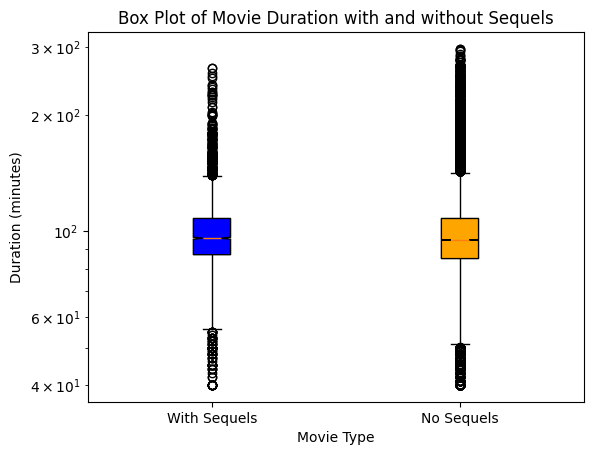

In [105]:
# Combine the duration data into a list for box plot creation
duration_data = [filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime']]

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration with and without Sequels')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['With Sequels', 'No Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()

Let's perform a t-test to see if there is a significant difference in the mean of the duration of feature films with sequels and feature films without sequels.

In [106]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(filtered_with_sequels_duration['Runtime'], filtered_no_sequels_duration['Runtime'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in duration between (filtered) movies with sequels and without sequels.')


T-test Statistic: 2.6466075005227463
P-value: 0.008164120246546142
Reject the null hypothesis: There is a significant difference in duration between (filtered) movies with sequels and without sequels.


### Month of release

Some of the dates are just years, our initial task would be to extract the month from those that include a month.

In [107]:
# Extract the month from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Month'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month
df_no_sequels.loc[:,'Month'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='%Y-%m-%d', errors='coerce').dt.month

# Drop rows with missing month data for movies with and without sequels
with_sequels_months = df_has_sequels.dropna(subset=['Month'])
no_sequels_months = df_no_sequels.dropna(subset=['Month'])

In [108]:
count_months_sequels = with_sequels_months.groupby('Month')['Month'].sum()
count_months_no_sequels = no_sequels_months.groupby('Month')['Month'].sum()

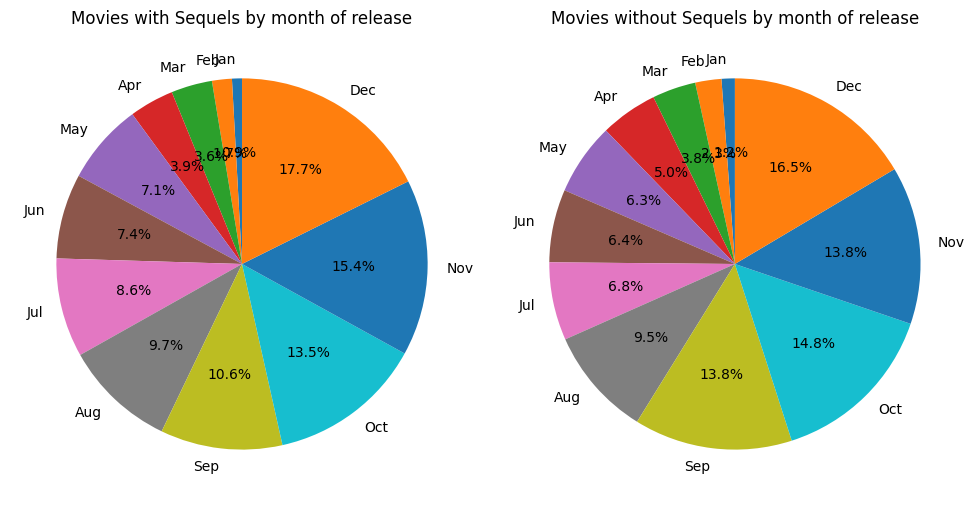

In [109]:
months = list(map(lambda x: calendar.month_abbr[x], np.arange(1,13)))

# Calculate percentages
percent_sequels = count_months_sequels / count_months_sequels.sum() * 100
percent_no_sequels = count_months_no_sequels / count_months_no_sequels.sum() * 100

# Plot pie chart for movies with sequels
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.pie(percent_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies with Sequels by month of release')

# Plot pie chart for movies without sequels
plt.subplot(1, 2, 2)
plt.pie(percent_no_sequels, labels=months, autopct='%1.1f%%', startangle=90)
plt.title('Movies without Sequels by month of release')

plt.tight_layout()
plt.show()


### Year of release

In [110]:
# Extract the year from the ReleaseDate column for movies with and without sequels
df_has_sequels.loc[:,'Year'] = pd.to_datetime(df_has_sequels['ReleaseDate'], format='mixed').dt.year
df_no_sequels.loc[:,'Year'] = pd.to_datetime(df_no_sequels['ReleaseDate'], format='mixed').dt.year

# Extract the year from the dataset, will be useful later
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

# Drop rows with missing year data for movies with and without sequels
with_sequels_year = df_has_sequels.dropna(subset=['Year'])
no_sequels_year = df_no_sequels.dropna(subset=['Year'])

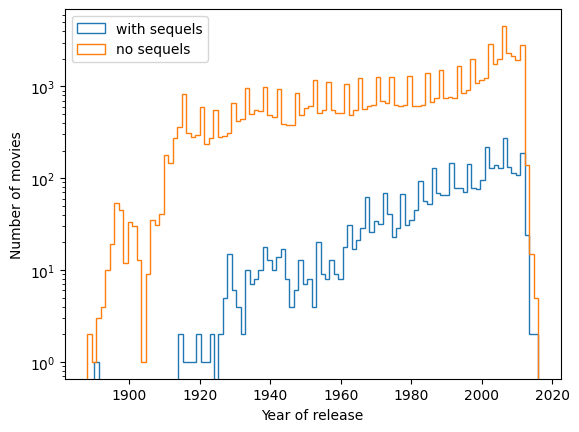

In [111]:
# Plot the year of release of movies with sequels and those without sequels using a histogram with a logarithmic scale on the y-axis.
n_bins = 100
plt.hist(with_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='with sequels')
plt.hist(no_sequels_year['Year'], bins=n_bins, log=True, histtype="step",  label='no sequels')
plt.xlabel('Year of release')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

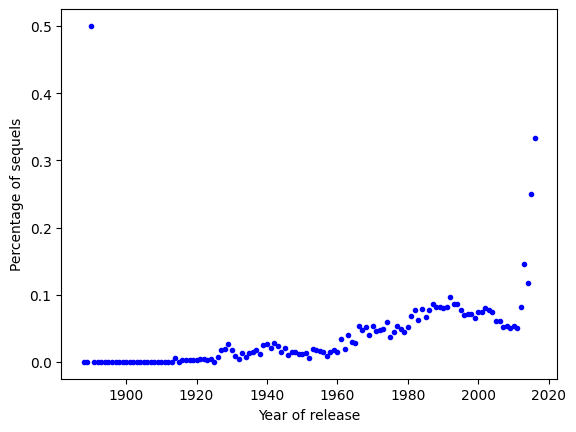

In [112]:
# Plotting the percentage of movies with and without sequels per year
sequels_per_year = with_sequels_year.groupby('Year')['Year'].count()
no_sequels_per_year = no_sequels_year.groupby('Year')['Year'].count()

# Create a new array with data for all years
all_years = np.arange(cmu_movies['Year'].min(), cmu_movies['Year'].max() + 1)

# Fill in missing values with zeros
sequels_per_year = sequels_per_year.reindex(all_years, fill_value=0)
no_sequels_per_year = no_sequels_per_year.reindex(all_years, fill_value=0)

# Plot the percentage of sequels per year
plt.plot(all_years, sequels_per_year/(sequels_per_year + no_sequels_per_year), 'b.')
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')
plt.show()

The plot appears to indicate a rising trend, but before delving deeper, let's examine the distribution within our dataset. 

In [113]:
cmu_movies.loc[:,'Year'] = pd.to_datetime(cmu_movies['ReleaseDate'], format='mixed').dt.year
movie_per_year = cmu_movies.groupby('Year')['Year'].count()

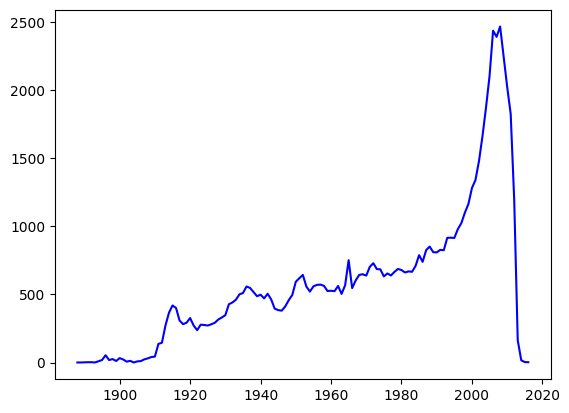

In [114]:
plt.plot(all_years, movie_per_year, 'b-')

It appears that the dataset has fewer entries after the year 2013. Therefore, for a more accurate analysis, we should limit our exploration of trends to data up to the year 2013. Additionally, the year 1890 stands out as an outlier concerning sequels, with only two movies recorded during that year, and one of them being a sequel.

The slope is  : [[0.00076065]]


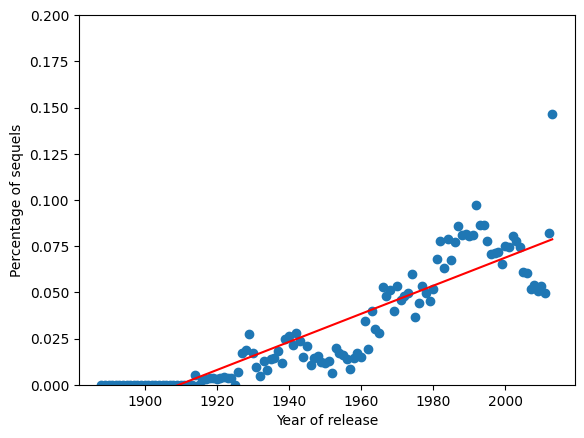

In [115]:
# Plotting the percentage of movies with and without sequels per year
sequels_per_year_b2013 = with_sequels_year[with_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()
no_sequels_per_year_b2013 = no_sequels_year[no_sequels_year['Year'] <= 2013].groupby('Year')['Year'].count()

# Create a new array with data for all years
all_years_b2013 = np.arange(cmu_movies['Year'].min(), 2014)

# Fill in missing values with zeros
sequels_per_year_b2013 = sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)
no_sequels_per_year_b2013 = no_sequels_per_year_b2013.reindex(all_years_b2013, fill_value=0)

#Fix outlier
sequels_per_year_b2013.iloc[2] = 0

# Linear regression to interpret the slope of the trend
lr = LinearRegression()
x = all_years_b2013.reshape(-1, 1)
y = (sequels_per_year_b2013/(sequels_per_year_b2013 + no_sequels_per_year_b2013)).values.reshape(-1, 1)
lr.fit(x, y)
y_hat = lr.predict(x)

print(f'The slope is  : {lr.coef_}')

# Plot the percentage of sequels per year
plt.scatter(all_years_b2013, sequels_per_year_b2013/(sequels_per_year_b2013 + no_sequels_per_year_b2013))
plt.plot(all_years_b2013, y_hat, 'r-')
plt.xlabel('Year of release')
plt.ylabel('Percentage of sequels')

#limit plot as we are plotting percentages
plt.ylim(0, 0.20)
plt.show()

By fitting a linear regression to the available data, we observe a positive slope. However, the plot suggests a more sinusoidal trend. It's important to note that attempting to predict future trends with such limited information may not yield meaningful results. The nature of the data, especially if it appears sinusoidal, may require more sophisticated modeling techniques for accurate predictions. 

### Country of Origin

In [116]:
with_sequels_countries = df_has_sequels.dropna(subset=['Countries'])
no_sequels_countries = df_no_sequels.dropna(subset=['Countries'])

Let's randomly pick a movie and see how the countries of origin are represented in the dataset.

In [117]:
print(with_sequels_countries.iloc[42]['Countries'])
print(type(with_sequels_countries.iloc[42]['Countries']))

{"/m/09c7w0": "United States of America"}
<class 'str'>


This representation is not ideal to conduct our analysis, let's switch it for a more efficient one.

In [118]:
def parse_countries(country_str):
    try:
        # Convert the string to a dictionary
        country_dict = json.loads(country_str)

        # Return the list of country names
        return list(country_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list or some default value
        return []

# Update 'Countries' column to contain lists of country names
with_sequels_countries['Countries'] = with_sequels_countries['Countries'].apply(parse_countries)
no_sequels_countries['Countries'] = no_sequels_countries['Countries'].apply(parse_countries)

We know that movies can have many countries of origin, combining different regions across the world. Let's take a closer look at the distribution.

In [119]:
with_sequels_countries['Countries'].describe()

count                           3837
unique                           275
top       [United States of America]
freq                            1692
Name: Countries, dtype: object

In [120]:
no_sequels_countries['Countries'].describe()

count                          77904
unique                          2059
top       [United States of America]
freq                           28608
Name: Countries, dtype: object

Our analysis reveals that there are 275 unique combinations of origin countries for movies with sequels, and 2059 for those without sequels. Intriguingly, the most frequently occurring 'combination' of origin in our dataset is, in fact, a single country - the United States of America. This 'combination' appears 1692 times in movies with sequels and 28608 times in movies without sequels.
 
This is a nuanced observation: while the USA often appears on its own as a country of origin, we suspect that numerous other combinations also feature the USA alongside different countries. This distinction points to the USA's dominant role in film production, both as a solitary player and in international partnerships. Now, we will delve deeper to ascertain the most frequent individual country of origin across all movies, furthering our understanding of global film production trends.

In [121]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_with_sequels = country_frequency_with_sequels.idxmax()
most_frequent_country_freq_with_sequels = country_frequency_with_sequels.max()

# Output the results
print(f"Most frequent country in movies with sequels: {most_frequent_country_with_sequels}")
print(f"Frequency of {most_frequent_country_with_sequels}: {most_frequent_country_freq_with_sequels}")

Most frequent country in movies with sequels: United States of America
Frequency of United States of America: 2124


In [122]:
# Use explode() and value_counts() to get the frequency of each country
country_frequency_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Get the most frequent country and its frequency
most_frequent_country_no_sequels = country_frequency_no_sequels.idxmax()
most_frequent_country_freq_no_sequels = country_frequency_no_sequels.max()

# Output the results
print(f"Most frequent country in movies without sequels: {most_frequent_country_no_sequels}")
print(f"Frequency of {most_frequent_country_no_sequels}: {most_frequent_country_freq_no_sequels}")

Most frequent country in movies without sequels: United States of America
Frequency of United States of America: 32284


In [123]:
print(f'Percentage of movies with sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_with_sequels/len(with_sequels_countries) * 100:.2f}%')
print(f'Percentage of movies with no sequels where the USA is one of the countries of Origin : {most_frequent_country_freq_no_sequels/len(no_sequels_countries) * 100:.2f}%')

Percentage of movies with sequels where the USA is one of the countries of Origin : 55.36%
Percentage of movies with no sequels where the USA is one of the countries of Origin : 41.44%


It seems like we found something interesting here: even though the USA is the top original countries for both movies with and without sequels, it looks like movies with sequels are more likely to have the USA appear in their countries of origin. Let's perform a test to investigate more. We choose to perform a Chi-square test because it works well with frequency data, which involves counts of occurrences. In our analysis, this is relevant for evaluating how often the USA appears as a country of origin in movies with and without sequels

In [124]:
from scipy.stats import chi2_contingency

# number of movies with sequels without USA as origin
with_sequels_non_usa = len(with_sequels_countries) - most_frequent_country_freq_with_sequels

# number of movies without sequels without USA as origin
without_sequels_non_usa = len(no_sequels_countries) - most_frequent_country_freq_no_sequels

# Creating the contingency table
contingency_table = [[most_frequent_country_freq_with_sequels, with_sequels_non_usa], 
                     [most_frequent_country_freq_no_sequels, without_sequels_non_usa]]

# Perform Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")

# Decision based on p-value
alpha = 0.05
if p < alpha:
    print(f"We reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin."
else:
    print(f"We fail to reject the null hypothesis at the {alpha} significance level.")
    conclusion = "This indicates that there is no significant association between movies having a sequel and the presence of the USA as a country of origin."

print(conclusion)

Chi-square statistic: 289.9215611583809
P-value: 5.171868052899045e-65
We reject the null hypothesis at the 0.05 significance level.
This suggests a significant association between movies having a sequel and the presence of the USA as a country of origin.


Now, let's put the USA aside and take a closer look at which other countries tend to appear as countries of origin.

In [125]:
# Count unique countries for movies with sequels
num_unique_countries_with_sequels = len(with_sequels_countries['Countries'].explode().unique())

# Count unique countries for movies without sequels
num_unique_countries_no_sequels = len(no_sequels_countries['Countries'].explode().unique())

# Output the results
print(f"Number of unique countries in movies with sequels: {num_unique_countries_with_sequels}")
print(f"Number of unique countries in movies without sequels: {num_unique_countries_no_sequels}")


Number of unique countries in movies with sequels: 71
Number of unique countries in movies without sequels: 148


Let's visualize what the top countries are in both categories. For readability, let's focus on the top-20 countries.

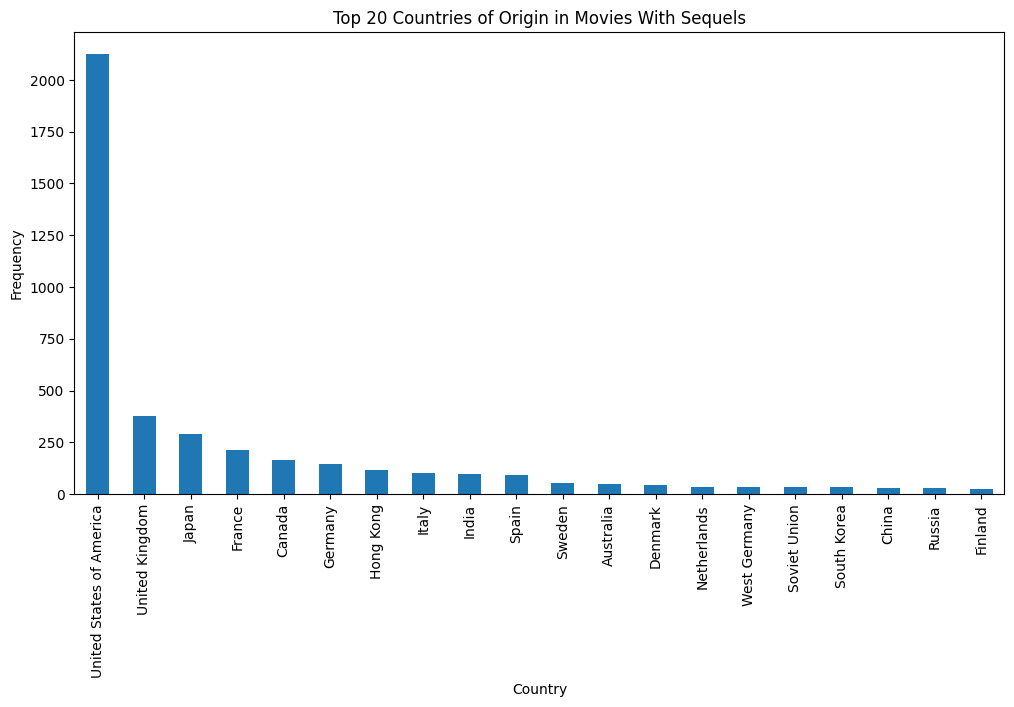

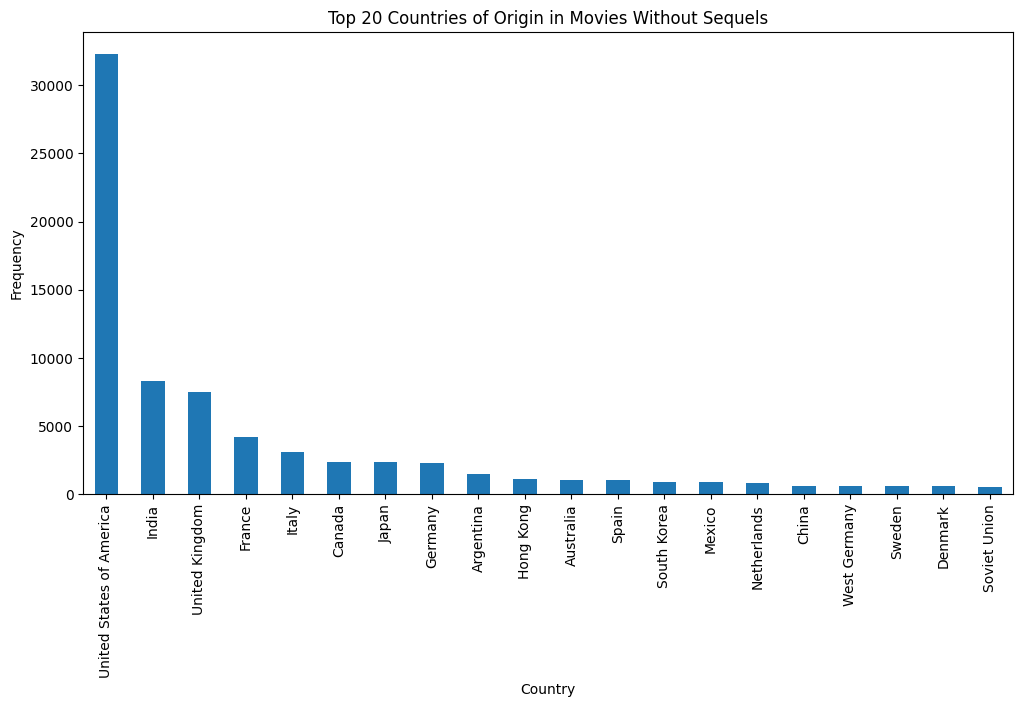

In [126]:
# Count the frequency of each country for movies with sequels
country_freq_with_sequels = with_sequels_countries['Countries'].explode().value_counts()

# Count the frequency of each country for movies without sequels
country_freq_no_sequels = no_sequels_countries['Countries'].explode().value_counts()

# Select the top 20 countries for movies with sequels
top_countries_with_sequels = country_freq_with_sequels.head(20)

# Select the top 20 countries for movies without sequels
top_countries_no_sequels = country_freq_no_sequels.head(20)

# Plot for the top 20 countries in movies with sequels
plt.figure(figsize=(12, 6))
top_countries_with_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies With Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

# Plot for the top 20 countries in movies without sequels
plt.figure(figsize=(12, 6))
top_countries_no_sequels.plot(kind='bar')
plt.title('Top 20 Countries of Origin in Movies Without Sequels')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability

# Show the plot
plt.show()

It is quite difficult to compare the two bar plots as they are not scaled. Let's compare the movies with and without sequels when looking at the percentage of movie per country. As the top countries are not exactly the same, we grouped the 22 countries that appear at least once in the top list.

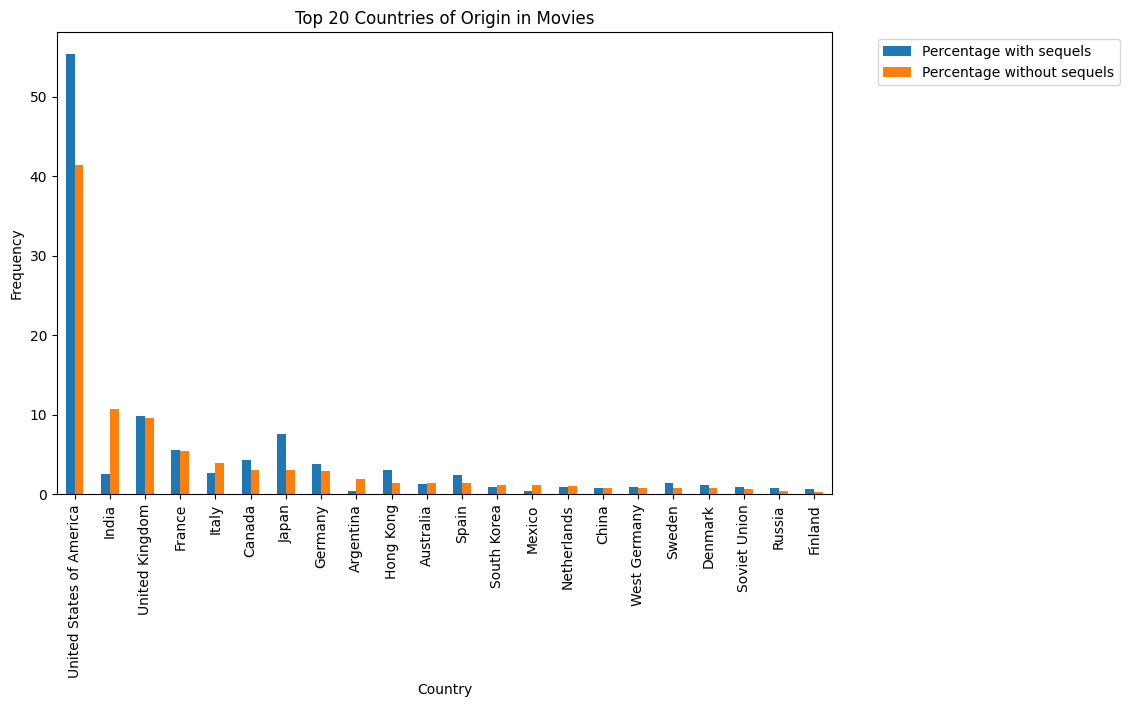

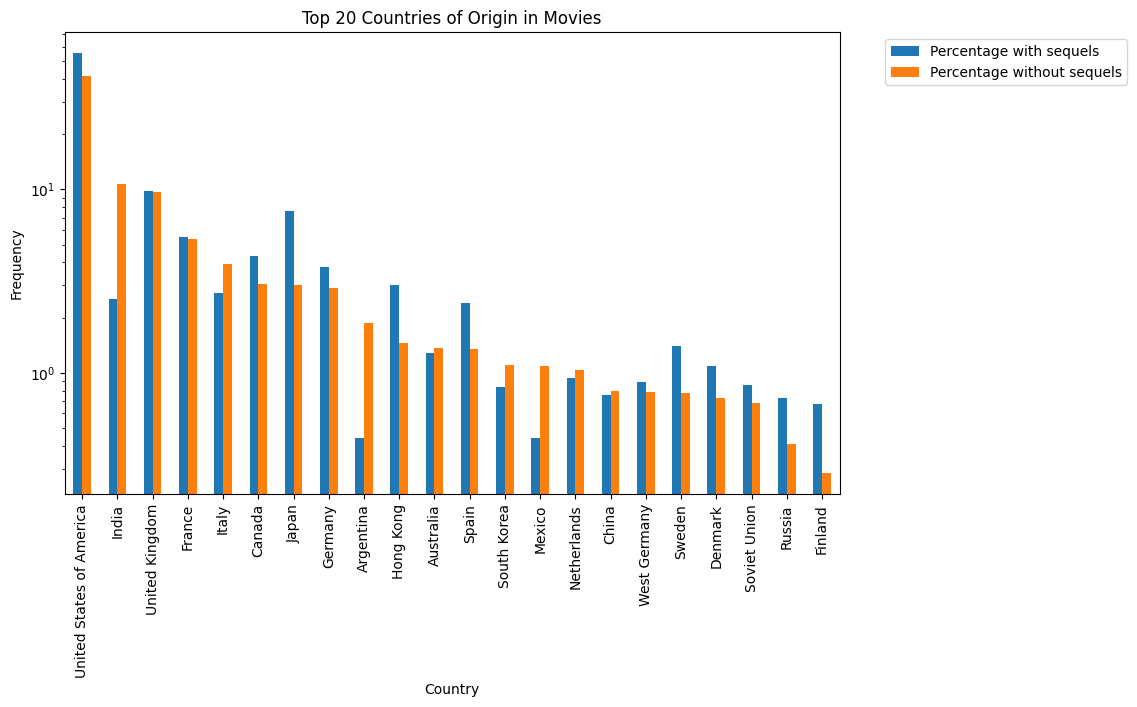

In [127]:
# Top 22 countries for movies with or without sequels
top_countries = ['United States of America', 'India', 'United Kingdom', 'France', 'Italy', 'Canada', 'Japan', 'Germany', 'Argentina', 'Hong Kong', 'Australia', 
                 'Spain', 'South Korea', 'Mexico', 'Netherlands', 'China', 'West Germany', 'Sweden', 'Denmark', 'Soviet Union', 'Russia', 'Finland']

# Create a dataframe that contains the percentage of movies made in each country 
df_countries = pd.DataFrame(index=top_countries, columns=['Percentage with sequels', 'Percentage without sequels'], data=0).astype(float)
for i, country in enumerate(top_countries):
    df_countries.iloc[i,0] = country_freq_with_sequels[country]/len(with_sequels_countries['Countries']) * 100
    df_countries.iloc[i,1] = country_freq_no_sequels[country]/len(no_sequels_countries['Countries']) * 100

# Plot for the top 22 countries in movies
ax = df_countries.plot(kind='bar', figsize=(10, 6), rot=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Top 20 Countries of Origin in Movies')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability
plt.show()

# Plot for the top 22 countries in movies in log scale
ax = df_countries.plot(kind='bar', logy=True, figsize=(10, 6), rot=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Top 20 Countries of Origin in Movies')
plt.xlabel('Country')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate the country names for better readability
plt.show()

What about the number of countries of origin per movie?

In [128]:
# Retrieve the countries of origin in each movie
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

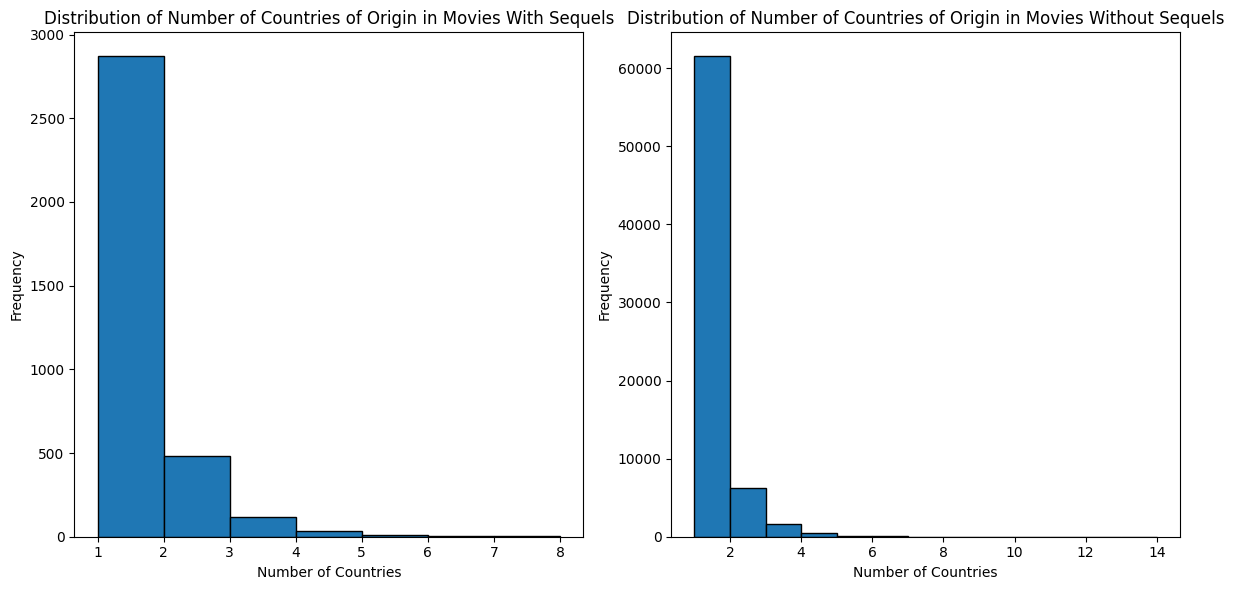

In [129]:
# Count the number of origin countries in each movie
with_sequels_countries['num_countries'] = with_sequels_countries['Countries'].apply(lambda x: len(x))
no_sequels_countries['num_countries'] = no_sequels_countries['Countries'].apply(lambda x: len(x))

# Plotting
plt.figure(figsize=(12, 6))

# Histogram for movies with sequels
plt.subplot(1, 2, 1)
plt.hist(with_sequels_countries['num_countries'], bins=range(1, with_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies With Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

# Histogram for movies without sequels
plt.subplot(1, 2, 2)
plt.hist(no_sequels_countries['num_countries'], bins=range(1, no_sequels_countries['num_countries'].max() + 1), edgecolor='black')
plt.title('Distribution of Number of Countries of Origin in Movies Without Sequels')
plt.xlabel('Number of Countries')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


Let's get some numbers.

In [130]:
with_sequels_countries['num_countries'].describe()

count    3837.000000
mean        1.151681
std         0.691020
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         8.000000
Name: num_countries, dtype: float64

In [131]:
no_sequels_countries['num_countries'].describe()

count    77904.000000
mean         1.052834
std          0.619696
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: num_countries, dtype: float64

We can see that countries with sequels have an average number of countries of origin of 1.15, while movies with no sequels have a lower average with a mean number of countries of original equal to 1.05.
This suggests that countries with sequels tend ot have a higher number of countries of origin.

In [132]:
# test??

### Movie genre

In [133]:
with_sequels_genres = df_has_sequels.dropna(subset=['Genres'])
no_sequels_genres = df_no_sequels.dropna(subset=['Genres'])

We select a random movie to examine how the genres are distributed.

In [134]:
print(with_sequels_genres.iloc[42]['Genres'])
print(type(with_sequels_genres.iloc[42]['Genres']))

{"/m/0hj3myq": "Children's/Family", "/m/0hj3n6r": "Holiday Film", "/m/01z4y": "Comedy", "/m/0hj3n62": "Heavenly Comedy", "/m/0hj3myc": "Children's Fantasy"}
<class 'str'>


Let's switch it for a more efficient representation, as we did for the country of origin.

In [135]:
def parse_genres(genre_str):
    try:
        # Convert the string to a dictionary and write all the genres with lower cases
        genre_dict = json.loads(genre_str.lower())

        # Return the list of genre names
        return list(genre_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list or some default value
        return []

# Update 'Genres' column to contain lists of genre names
with_sequels_genres['Genres'] = with_sequels_genres['Genres'].apply(parse_genres)
no_sequels_genres['Genres'] = no_sequels_genres['Genres'].apply(parse_genres)

We will now explore the top genres, because it seems that some genre names are different but with the same meaning.

In [136]:
# Count the frequency of each genre for movies with sequels
genre_freq_with_sequels = with_sequels_genres['Genres'].explode().value_counts()

# Count the frequency of each genre for movies without sequels
genre_freq_no_sequels = no_sequels_genres['Genres'].explode().value_counts()

# Print the top 20 genres for movies with and without sequels
print(f'Top genres for movies with sequels: \n {genre_freq_with_sequels.head(20)} \n')
print(f'Top genres for movies without sequels: \n {genre_freq_no_sequels.head(20)}')

Top genres for movies with sequels: 
 Genres
comedy               1081
drama                 938
action                790
thriller              726
adventure             631
horror                616
family film           601
action/adventure      526
animation             476
world cinema          413
crime fiction         408
fantasy               405
science fiction       404
romance film          339
japanese movies       274
children's/family     243
cult                  242
mystery               222
music                 207
short film            205
Name: count, dtype: int64 

Top genres for movies without sequels: 
 Genres
drama               33069
comedy              15268
romance film         9895
black-and-white      8947
thriller             8018
action               8008
short film           7936
world cinema         6742
indie                6710
crime fiction        6540
documentary          5473
silent film          5234
horror               4664
adventure            

We can see that some genres are redundant: 'comedy' and 'comedy film' for example. So we decide to either create a list of 22 genres, containing the top 20 genres of movies with and without sequels. Then we select all films that contains a genre. If we look at the previous example, in our list of top genres we will only take 'comedy', but as 'comedy film' also contains the word it will also be selected. As we transform the genres to have only lower cases, there would be no problem with 'Drama' and 'Romantic drama' for example. Let's better visualize the differences.

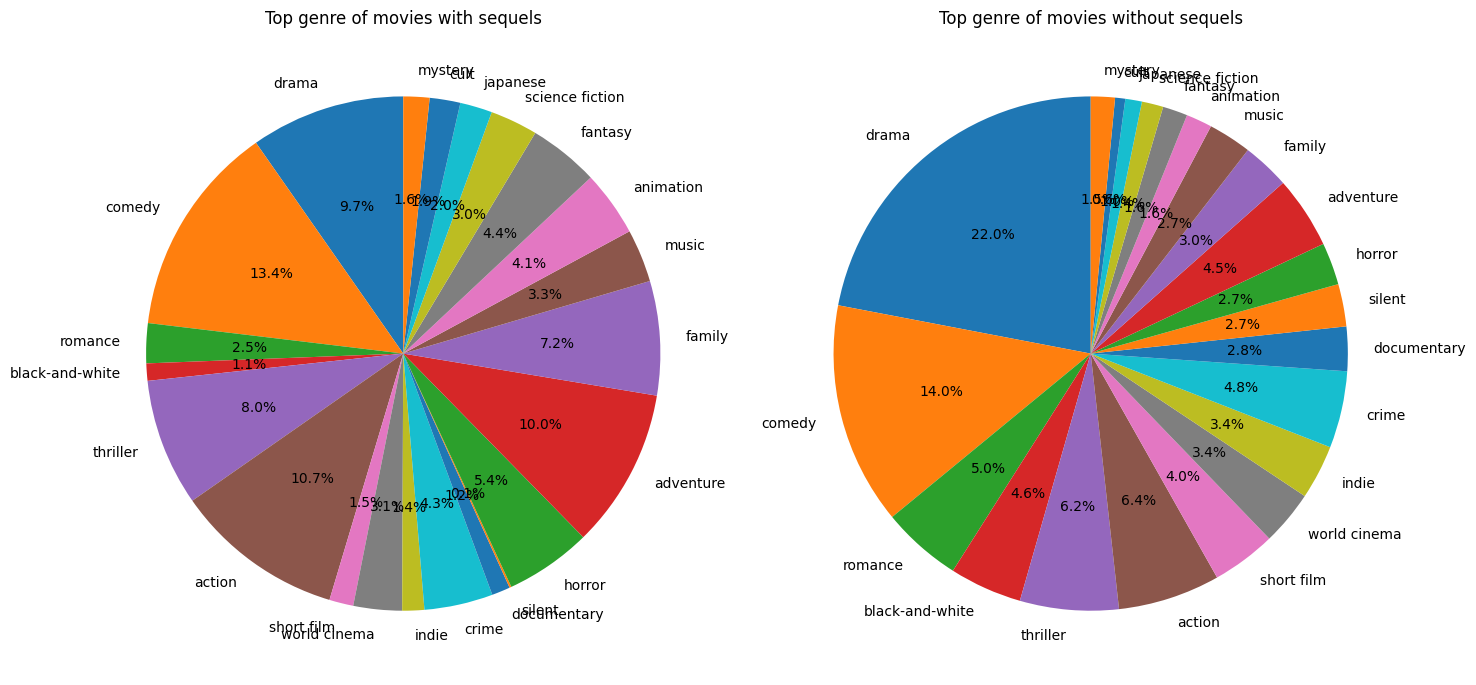

In [137]:
# List of the top genres
top_genres = ['drama', 'comedy', 'romance', 'black-and-white', 'thriller', 'action', 'short film', 'world cinema', 'indie', 'crime', 'documentary', 
              'silent', 'horror', 'adventure', 'family', 'music', 'animation', 'fantasy', 'science fiction', 'japanese', 'cult', 'mystery'] 


# Count the occurrences of each top genre
def count_top_genre(genre_freq_series, top_genre):
    return genre_freq_series[genre_freq_series.index.str.contains(top_genre, case=False)].sum()

# Get the frequency of each top genre
top_genres_freq_with_sequels = [count_top_genre(genre_freq_with_sequels, genre) for genre in top_genres]
top_genres_freq_no_sequels = [count_top_genre(genre_freq_no_sequels, genre) for genre in top_genres]

# Plot pie chart for movies with sequels
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie(top_genres_freq_with_sequels, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of movies with sequels')

# Plot pie chart for movies with sequels
plt.subplot(1, 2, 2)
plt.pie(top_genres_freq_no_sequels, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of movies without sequels')

plt.tight_layout()
plt.show()

We see lots of differences between films with or without sequels.

(MORE EXPLANATION)

Now we try to investiguate how the pairs of genre are linked, for example is the pair comedy/drama more present in movies with or without sequels? What kind of differences can we observed? To answer this question, let's create heatmaps to visualize the correlation between two genres.

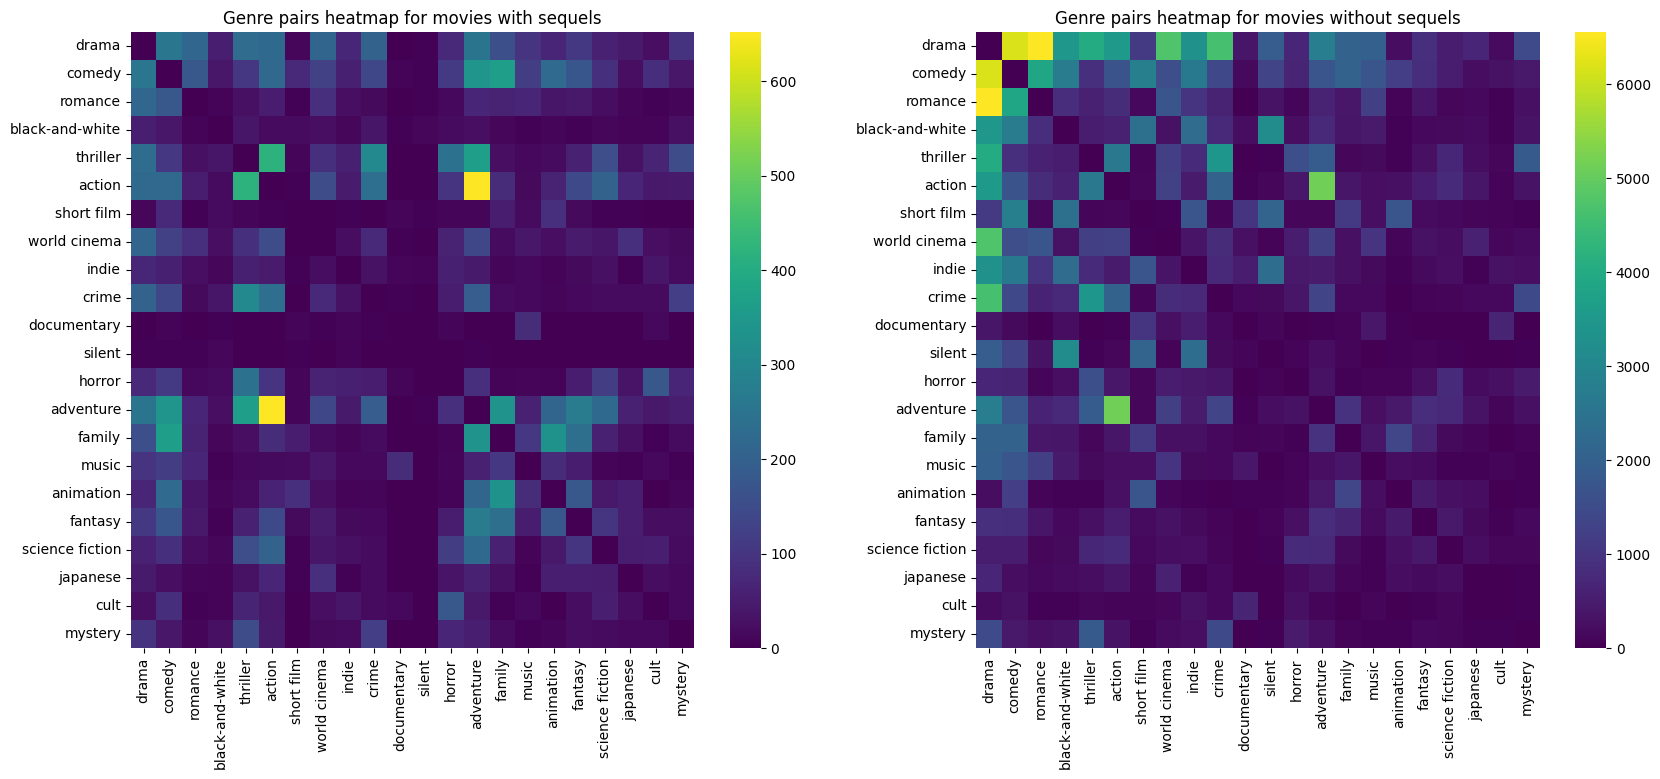

In [138]:
# Check if a pair of genres is present in a movie
def genre_pair_presence(genre_list, genre_pair):
    return all(any(genre in full_genre for full_genre in genre_list) for genre in genre_pair)

# Create a matrix for genre pairs for movie with and without sequels
genre_pair_matrix_with_sequels = pd.DataFrame(index=top_genres, columns=top_genres, data=0)
genre_pair_matrix_no_sequels = pd.DataFrame(index=top_genres, columns=top_genres, data=0)

# Iterate through pairs of genres 
for genre1 in top_genres:
    for genre2 in top_genres:
        if genre1 != genre2:
            genre_pair = [genre1, genre2]
            
            # Check if the pair is present in each movie and count
            genre_pair_matrix_with_sequels.at[genre1, genre2] = len(with_sequels_genres[with_sequels_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])
            genre_pair_matrix_no_sequels.at[genre1, genre2] = len(no_sequels_genres[no_sequels_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])

# Plot the heatmaps
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(genre_pair_matrix_with_sequels, cmap='viridis', fmt='d', ax=ax1)
sns.heatmap(genre_pair_matrix_no_sequels, cmap='viridis', fmt='d', ax=ax2)
ax1.set_title('Genre pairs heatmap for movies with sequels')
ax2.set_title('Genre pairs heatmap for movies without sequels')
plt.show()

Movies without sequels seems to have more correlated pairs than movies with sequels. In the heatmap of movie with sequels, the pair action/adventure is highly correlated, and also the pair action/thriller. 

(MORE EXPLANATION)

### Characters exploration

Let us now start our exploration of the characters in our movies.

In [139]:
all_characters_df = pd.read_csv("movie_summaries/character.metadata.tsv", sep='\t', engine='c', 
                                names = ['WikipediaID', 'MovieReleaseDate', 
                                         'CharacterName', 'ActorDOB', 'ActorGender', 'ActorHeight', 
                                         'ActorName', 'ActorAgeAtRelease'],
                                         usecols=[0, 2, 3, 4, 5, 6, 8, 9])

all_characters_df.describe()

,WikipediaID,ActorHeight,ActorAgeAtRelease
count,4.506630e+05,154824.000000,292555.000000
mean,1.396956e+07,1.788893,37.819918
std,1.079650e+07,4.379940,14.323909
min,3.300000e+02,0.610000,-937.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366451e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


We can imemdiately see that there are some issue with our data. For example, we can see that our dataset contains at least one negative value for 'ActorAgeAtRelease', which does not make a lot of sense. We also suspect that we will be dealing with some missing values. So we start by defining a method, infer_ages_at_release, which will hopefully help us recover some data related to the age of the actors at the release of the movie, by using the date of birth of the actor and the movie's release date.

In [140]:
def infer_ages_at_release(df):

    print(f"Percentage of missing or incorrect actor age at release before infering: {(len(df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)])/len(df))*100}%")

    for index, row in df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)].iterrows():

        if not pd.isnull(row['ActorDOB']) and not pd.isnull(row['MovieReleaseDate']):
            try:
                dob = pd.to_datetime(row['ActorDOB']).tz_localize(None)
            except:
                print(f"error for dob {row['ActorDOB']} - index {index}")

            try:
                release_date = pd.to_datetime(row['MovieReleaseDate']).tz_localize(None)
            except:
                print(f"error for release date {row['MovieReleaseDate']} - index {index}")

            try:
                actor_at_release = release_date - dob
                df.loc[index, 'ActorAgeAtRelease'] = floor(actor_at_release.days / 365)
            except:
                print(f"Substraction failed for {release_date} - {dob} - index {index}")

    print(f"Percentage of missing or incorrect actor age at release after infering: {(len(df[(df['ActorAgeAtRelease'].isnull()) | (df['ActorAgeAtRelease'] < 0)])/len(df))*100}%")

infer_ages_at_release(all_characters_df)

# We had to supress the line for Lu Xun, a Chinese general from the year 183 that we are 99% sure did not act in acclaimed 2005 movie Jasmine Women. And we also had to manually correct a few rows with invalid data, such as a film released in 2010 and not 1010.


Percentage of missing or incorrect actor age at release before infering: 35.16574469170977%
Percentage of missing or incorrect actor age at release after infering: 25.66352241031547%


Looks like we successfully managed to save almost 10% of our data for the age at movie release column. Now, we can start doing some further analysis. As usual, let us create two dataframes, one for movies with sequels, and one for movies without sequels.

In [141]:
# Extract movie IDs
movies_with_sequels_ids = set(df_has_sequels['WikipediaID'])
movies_no_sequels_ids = set(df_no_sequels['WikipediaID'])

# Filter characters based on whether their movie ID is in the sequels or no-sequels list
characters_with_sequels = all_characters_df[all_characters_df['WikipediaID'].isin(movies_with_sequels_ids)]
characters_no_sequels = all_characters_df[all_characters_df['WikipediaID'].isin(movies_no_sequels_ids)]

# Group by WikipediaID
grouped_characters_with_sequels = characters_with_sequels.groupby('WikipediaID')
grouped_characters_no_sequels = characters_no_sequels.groupby('WikipediaID')

#### Gender of the Actors

In [142]:
with_sequels_gender = characters_with_sequels.dropna(subset=['ActorGender'])
no_sequels_gender = characters_no_sequels.dropna(subset=['ActorGender'])

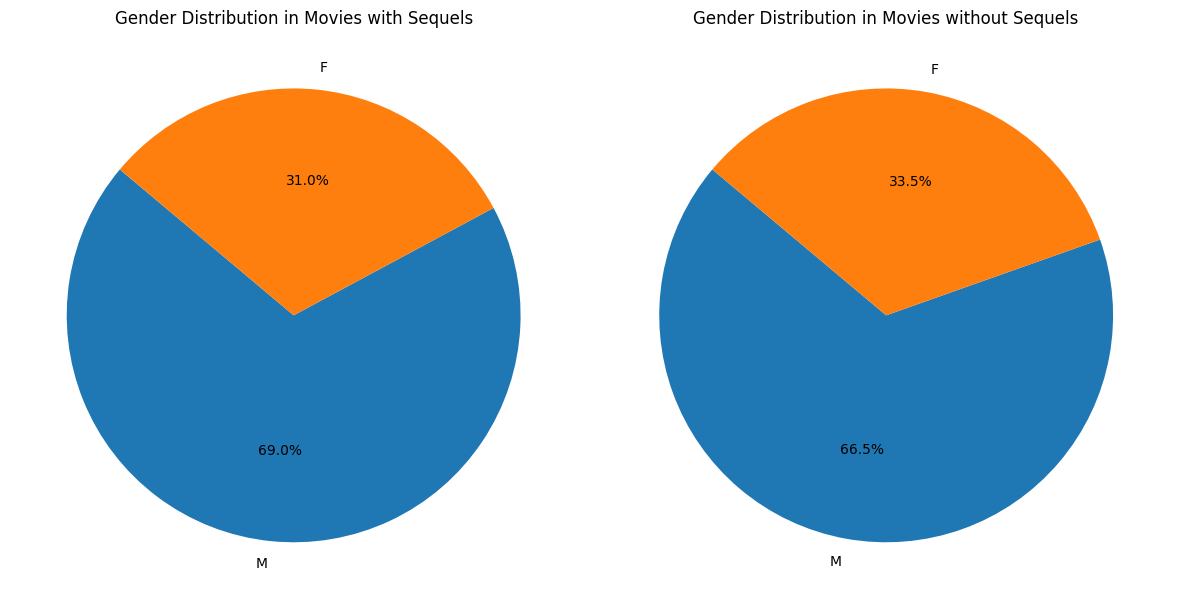

In [143]:
def plot_gender_distribution_pie(ax, df, title):
    # Calculate counts
    counts = df['ActorGender'].value_counts()
    
    # Create pie chart on the given Axes object
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(title)

# Set up the matplotlib figure for side-by-side plots
plt.figure(figsize=(12, 6))  # Adjusted for overall smaller and side-by-side layout

# Create subplot for movies with sequels
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plot_gender_distribution_pie(ax1, with_sequels_gender, 'Gender Distribution in Movies with Sequels')

# Create subplot for movies without sequels
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plot_gender_distribution_pie(ax2, no_sequels_gender, 'Gender Distribution in Movies without Sequels')

# Display the plots
plt.tight_layout()
plt.show()

The gender distribution across both movie categories reveals a notable imbalance, with female characters constituting just 31% of the cast in movies with sequels, and marginally higher at 33.5% in movies without sequels. Such figures underscore the persistent underrepresentation of women in the film industry. The increment in female presence within films in the second category, though slight, raises questions about its statistical significance and whether a correlation exists between the propensity of sequels and a reduced proportion of female roles. To evaluate the validity of this observation, we employ a statistical hypothesis test to determine if the difference is indeed significant.

In [144]:
# Convert gender to numeric: 1 for female (F) and 0 for male (M)
numeric_with_sequels = with_sequels_gender['ActorGender'].apply(lambda x: 1 if x == 'F' else 0)
numeric_no_sequels = no_sequels_gender['ActorGender'].apply(lambda x: 1 if x == 'F' else 0)

# Perform the t-test
t_stat, p_value = ttest_ind(numeric_with_sequels, numeric_no_sequels, nan_policy='omit')

# Output the results
print(f'T-statistic: {t_stat}')
print(f'P-value: {p_value}')

# Conclusion based on the p-value
significance_level = 0.05
if p_value < significance_level:
    print(f'The test results are statistically significant (p < {significance_level}), suggesting a difference in the proportion of female characters between the two movie categories.')
else:
    print(f'The test results are not statistically significant (p >= {significance_level}), indicating no evidence of a difference in the proportion of female characters between the two movie categories.')

T-statistic: -8.793160749191763
P-value: 1.4596150806114725e-18
The test results are statistically significant (p < 0.05), suggesting a difference in the proportion of female characters between the two movie categories.


#### Age of the Actors

Now let us focus on the age of the actors. We have previously managed to fill some of the missing or invalid rows with the age of the actors at the release of the movie, whenever we had the date of birth and release date. However, these information were not always provided, so our dataframes need some further cleaning. We filter out the rows with missing values, and we ensure that the age is between 0 and 110 years.

In [145]:
with_sequels_age = characters_with_sequels.dropna(subset=['ActorAgeAtRelease'])
with_sequels_age = with_sequels_age[(with_sequels_age['ActorAgeAtRelease'] >= 0) & (with_sequels_age['ActorAgeAtRelease'] < 120)]

no_sequels_age = characters_no_sequels.dropna(subset=['ActorAgeAtRelease'])
no_sequels_age = no_sequels_age[(no_sequels_age['ActorAgeAtRelease'] >= 0) & (no_sequels_age['ActorAgeAtRelease'] < 120)]

We can now plot the age pyramids for both categories. This will allow us to also see how the age distribution changes as a function of the gender of the actor.

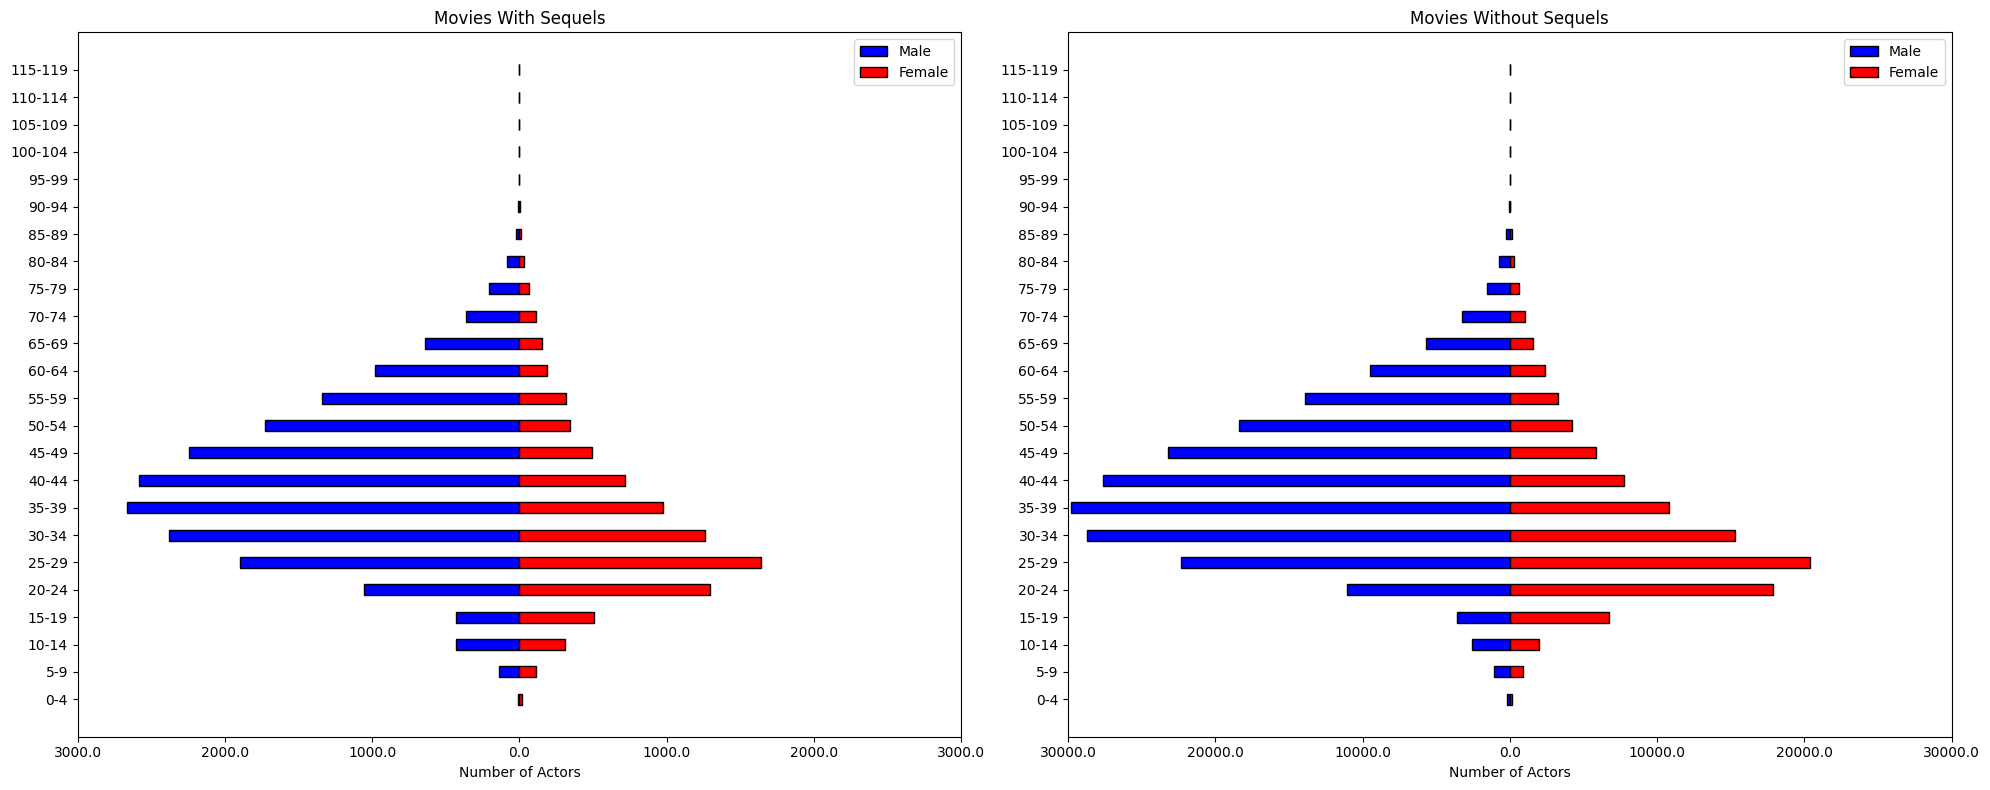

In [146]:
# à modifier pour que la dernière barre soit 100+

# Create age bins and labels for the age groups
bins = list(range(0, 121, 5))  # Adjust the range and bin width as needed
age_labels = [f'{i}-{i+4}' for i in range(0, 120, 5)]  # Create labels for the age groups

# Bin the age data for movies with sequels
with_sequels_age['AgeGroup'] = pd.cut(with_sequels_age['ActorAgeAtRelease'], bins=bins, labels=age_labels, right=False)
with_sequels_counts = with_sequels_age.groupby(['AgeGroup', 'ActorGender'], observed=False).size().unstack().fillna(0)

# Bin the age data for movies without sequels
no_sequels_age['AgeGroup'] = pd.cut(no_sequels_age['ActorAgeAtRelease'], bins=bins, labels=age_labels, right=False)
no_sequels_counts = no_sequels_age.groupby(['AgeGroup', 'ActorGender'], observed=False).size().unstack().fillna(0)

# Plotting the population pyramids
plt.figure(figsize=(20, 8))

# Plot for movies with sequels
plt.subplot(1, 2, 1)  # This creates the first subplot in a 1x2 grid
plt.barh(y=with_sequels_counts.index, width=-with_sequels_counts['M'].abs(), label='Male', color='blue', edgecolor='black', height=0.4)
plt.barh(y=with_sequels_counts.index, width=with_sequels_counts['F'].abs(), label='Female', color='red', edgecolor='black', height=0.4)
plt.xlabel('Number of Actors')
plt.title('Movies With Sequels')
plt.legend()
plt.xlim(-max(with_sequels_counts.max()), max(with_sequels_counts.max()))
ticks = plt.xticks()
plt.xticks(ticks[0], [str(abs(tick)) for tick in ticks[0]])

# Plot for movies without sequels
plt.subplot(1, 2, 2)  # This creates the second subplot in a 1x2 grid
plt.barh(y=no_sequels_counts.index, width=-no_sequels_counts['M'].abs(), label='Male', color='blue', edgecolor='black', height=0.4)
plt.barh(y=no_sequels_counts.index, width=no_sequels_counts['F'].abs(), label='Female', color='red', edgecolor='black', height=0.4)
plt.xlabel('Number of Actors')
plt.title('Movies Without Sequels')
plt.legend()
plt.xlim(-max(no_sequels_counts.max()), max(no_sequels_counts.max()))
ticks = plt.xticks()
plt.xticks(ticks[0], [str(abs(tick)) for tick in ticks[0]])

plt.tight_layout()  # Adjust the layout
plt.show()

The two pyramids look pretty similar, suggesting a similar distribution. Let's get some precise values.

In [147]:
# Calculating mean age of actors with sequels by gender
mean_age_with_sequels = with_sequels_age.groupby('ActorGender')['ActorAgeAtRelease'].mean()

# Calculating mean age of actors without sequels by gender
mean_age_no_sequels = no_sequels_age.groupby('ActorGender')['ActorAgeAtRelease'].mean()

# Displaying the results
print("Mean Age of Actors with Sequels:", mean_age_with_sequels)
print("\nMean Age of Actors without Sequels:")
print(mean_age_no_sequels)

Mean Age of Actors with Sequels: ActorGender
F    33.931378
M    41.568159
Name: ActorAgeAtRelease, dtype: float64

Mean Age of Actors without Sequels:
ActorGender
F    33.568504
M    41.181260
Name: ActorAgeAtRelease, dtype: float64


The data distinctly highlights a notable age disparity between male and female actors in both categories of films—those with sequels and without. In each case, female actors are noticeably younger than their male counterparts. For instance, in movies with sequels, the average age of female actors is around 33.93 years, which is significantly lower than the average age of male actors at approximately 41.57 years. This trend is similarly observed in films without sequels, where female actors have an average age of about 33.57 years, in contrast to male actors who average around 41.18 years. This consistent age gap across different types of films underscores a prevalent industry trend where female actors are, on average, younger than male actors. On the other hand, these numbers suggest a consistent age distribution across both genders, regardless of the presence of sequels, with a marginal increase in average age for actors in sequels.


## Part 2: Comparing the original movies and their sequels

We will begin by doing some initial comparaison on : 
* Earnings
* Duration
* Month of release
* Year of release
* Country of origin
* Film genre
* Characters
    * Age
    * Gender

First, we need to add a column containing the WikidataID for the movies and their sequels, as we do not have the WikipediaID for sequels. We also isolate the sequels ID needed to compare the movies.

In [148]:
# Add the WikidataID
cmu_movies['WikidataID'] = from_csv['WikidataID']

# Get the WikidataID of the sequels
sequels_id = pd.DataFrame()
sequels_id['WikidataID'] = originals_sequels['SequelID']

Then, we will look at the movies present in the cmu dataset by merging, and add the missing sequels information.

In [149]:
# Merge original_sequels with cmu_movie to get information about the sequels
df_sequels_cmu = pd.merge(sequels_id, cmu_movies, on='WikidataID')

# Read the dataset containing the missing metadata in cmu_movies
seq = pd.read_csv('missing_sequels_metadata.csv')

# Remove the additional columns
seq = seq.drop(['PrequelID', 'SequelID'], axis=1)

# Remove the duplicates
unique_column = ['WikipediaID', 'FreebaseID', 'MovieName', 'WikidataID']
seq = seq.drop_duplicates(subset=unique_column)

# Merge the originals_sequels with the missing metadata
df_sequels_missing = pd.merge(sequels_id, seq, on='WikidataID')

# Print the dataset
df_sequels_missing

,WikidataID,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,Q24272881,NaN,NaN,Mary Poppins Returns,19 December 2018,"346,800,000",130,English,NaN,musical film
1,Q3772186,NaN,NaN,Archie's Weird Mysteries,NaN,NaN,NaN,English,NaN,teen sitcom
2,Q4753295,NaN,NaN,And Do They Do/Zoo Caprices,NaN,NaN,NaN,NaN,NaN,contemporary classical music
3,Q29565371,NaN,NaN,Porous Pockets/Choir Boys,28 November 2008,NaN,"1,403±1",English,NaN,NaN
4,Q1354125,NaN,NaN,1969 film by Harald Reinl,1969,NaN,95±0,German,NaN,comedy film
...,...,...,...,...,...,...,...,...,...,...
1149,Q115932556,NaN,NaN,Twisters,19 July 2024,NaN,132.0,English,NaN,disaster film
1150,Q64069446,NaN,NaN,Coming 2 America,5 March 2021,NaN,110,English,NaN,comedy film
1151,Q3860653,NaN,NaN,Mondo cane n. 2,1963,NaN,100,NaN,NaN,documentary film
1152,Q12294915,NaN,NaN,Against All,1956,NaN,112,Czech,NaN,historical film


We see that there are some problems in this dataset. Box office values are strings and separated by commas. Same problem with Runtime. Let's clean these problems.

In [150]:
# Remove the commas
df_sequels_missing['BoxOffice'] = df_sequels_missing['BoxOffice'].replace(',', '', regex=True)

# Convert the column to floats
df_sequels_missing['BoxOffice'] = df_sequels_missing['BoxOffice'].astype(float)

In [151]:
# Remove the plus/minus sign and everything that follows in the 'Runtime' column
df_sequels_missing['Runtime'] = df_sequels_missing['Runtime'].replace(r'±.*', '', regex=True)
df_sequels_missing['Runtime'] = df_sequels_missing['Runtime'].replace(',', '', regex=True)

# Convert the 'Runtime' column to numeric values
df_sequels_missing['Runtime'] = df_sequels_missing['Runtime'].astype(float)

We also see that from the `sequels_missing` dataset, dates are represented localized rather than ISO 8601 (19 december 2018 v. 2018-12-19). Let's fix it.

In [153]:
from datetime import datetime
def fix_release_date(date):
    try:
        return datetime.strptime(str(date), '%d %B %Y').date()
    except: # this probably means it it just the year TODO ANTOINE: check ça mieux et les mettre en ISO-8601, aussi pour les autres années du dataset
        return date
df_sequels_missing['ReleaseDate'] = df_sequels_missing['ReleaseDate'].apply(fix_release_date)

display(df_sequels_missing)

,WikidataID,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,Q24272881,NaN,NaN,Mary Poppins Returns,19 December 2018,346800000.0,130.0,English,NaN,musical film
1,Q3772186,NaN,NaN,Archie's Weird Mysteries,NaN,NaN,NaN,English,NaN,teen sitcom
2,Q4753295,NaN,NaN,And Do They Do/Zoo Caprices,NaN,NaN,NaN,NaN,NaN,contemporary classical music
3,Q29565371,NaN,NaN,Porous Pockets/Choir Boys,28 November 2008,NaN,1403.0,English,NaN,NaN
4,Q1354125,NaN,NaN,1969 film by Harald Reinl,1969,NaN,95.0,German,NaN,comedy film
...,...,...,...,...,...,...,...,...,...,...
1149,Q115932556,NaN,NaN,Twisters,19 July 2024,NaN,132.0,English,NaN,disaster film
1150,Q64069446,NaN,NaN,Coming 2 America,5 March 2021,NaN,110.0,English,NaN,comedy film
1151,Q3860653,NaN,NaN,Mondo cane n. 2,1963,NaN,100.0,NaN,NaN,documentary film
1152,Q12294915,NaN,NaN,Against All,1956,NaN,112.0,Czech,NaN,historical film


,WikidataID,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,Q24272881,NaN,NaN,Mary Poppins Returns,2018-12-19,346800000.0,130.0,English,NaN,musical film
1,Q3772186,NaN,NaN,Archie's Weird Mysteries,NaN,NaN,NaN,English,NaN,teen sitcom
2,Q4753295,NaN,NaN,And Do They Do/Zoo Caprices,NaN,NaN,NaN,NaN,NaN,contemporary classical music
3,Q29565371,NaN,NaN,Porous Pockets/Choir Boys,2008-11-28,NaN,1403.0,English,NaN,NaN
4,Q1354125,NaN,NaN,1969 film by Harald Reinl,1969,NaN,95.0,German,NaN,comedy film
...,...,...,...,...,...,...,...,...,...,...
1149,Q115932556,NaN,NaN,Twisters,2024-07-19,NaN,132.0,English,NaN,disaster film
1150,Q64069446,NaN,NaN,Coming 2 America,2021-03-05,NaN,110.0,English,NaN,comedy film
1151,Q3860653,NaN,NaN,Mondo cane n. 2,1963,NaN,100.0,NaN,NaN,documentary film
1152,Q12294915,NaN,NaN,Against All,1956,NaN,112.0,Czech,NaN,historical film


Finally, we concatenate both.

In [154]:
# Concatenate the two dataframes to get the final result
df_sequels = pd.concat([df_sequels_cmu, df_sequels_missing], ignore_index=True)

In [155]:
df_sequels

,WikidataID,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres,Year
0,Q1213253,3384409.0,/m/025sq9n,The Gods Must Be Crazy II,1990-04-13,NaN,98.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti...",1990.0
1,Q544359,2853254.0,/m/086yz_,Iruvar,1997-01-14,NaN,113.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1997.0
2,Q2930441,4255260.0,/m/0bsms7,C.H.U.D II: Bud the C.H.U.D.,1988,NaN,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jb4p32"": ""Zombie Film"", ""/m/06vxwl5"": ""N...",1988.0
3,Q771537,2509885.0,/m/02p6k7z,Critters 4,1991,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H...",1991.0
4,Q1138932,289253.0,/m/01qd2t,Grease 2,1982-06-11,15171476.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/04t36"": ""M...",1982.0
...,...,...,...,...,...,...,...,...,...,...,...
3855,Q115932556,NaN,NaN,Twisters,2024-07-19,NaN,132.0,English,NaN,disaster film,NaN
3856,Q64069446,NaN,NaN,Coming 2 America,2021-03-05,NaN,110.0,English,NaN,comedy film,NaN
3857,Q3860653,NaN,NaN,Mondo cane n. 2,1963,NaN,100.0,NaN,NaN,documentary film,NaN
3858,Q12294915,NaN,NaN,Against All,1956,NaN,112.0,Czech,NaN,historical film,NaN


In [130]:
# Remove the duplicates
unique_column = ['WikipediaID', 'FreebaseID', 'MovieName', 'WikidataID']
df_sequels.drop_duplicates(subset=unique_column)

,WikidataID,WikipediaID,FreebaseID,MovieName,ReleaseDate,BoxOffice,Runtime,Languages,Countries,Genres
0,Q1213253,3384409.0,/m/025sq9n,The Gods Must Be Crazy II,1990-04-13,NaN,98.0,"{""/m/0x82"": ""Afrikaans Language"", ""/m/02h40lc""...","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/03k9fj"": ""Adventure"", ""/m/03btsm8"": ""Acti..."
1,Q544359,2853254.0,/m/086yz_,Iruvar,1997-01-14,NaN,113.0,"{""/m/07c9s"": ""Tamil Language""}","{""/m/03rk0"": ""India""}","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
2,Q2930441,4255260.0,/m/0bsms7,C.H.U.D II: Bud the C.H.U.D.,1988,NaN,84.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jb4p32"": ""Zombie Film"", ""/m/06vxwl5"": ""N..."
3,Q771537,2509885.0,/m/02p6k7z,Critters 4,1991,NaN,94.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""H..."
4,Q1138932,289253.0,/m/01qd2t,Grease 2,1982-06-11,15171476.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/04t36"": ""M..."
...,...,...,...,...,...,...,...,...,...,...
3855,Q115932556,NaN,NaN,Twisters,19 July 2024,NaN,132.0,English,NaN,disaster film
3856,Q64069446,NaN,NaN,Coming 2 America,5 March 2021,NaN,110.0,English,NaN,comedy film
3857,Q3860653,NaN,NaN,Mondo cane n. 2,1963,NaN,100.0,NaN,NaN,documentary film
3858,Q12294915,NaN,NaN,Against All,1956,NaN,112.0,Czech,NaN,historical film


In [131]:
originals_sequels.drop_duplicates(subset=['WikidataID'])

,WikipediaID,WikidataID,SequelID
17,77856,Q209170,Q24272881
41,9548445,Q4786598,Q3772186
49,261237,Q647665,Q1213253
135,1630107,Q602236,Q4753295
141,1072373,Q1728088,Q544359
...,...,...,...
81685,11350779,Q1216506,Q255314
81695,54540,Q493755,Q64069446
81707,30863646,Q1152330,Q3860653
81723,28373912,Q6150472,Q12294915


### Difference de 33 films... a voir ce qu'on fait ou sinon on enleve juste les print et on dit rien¶

In [132]:
#### START DES ANALYSES DE PART 2

### Earnings

Our initial approach involves creating a plot to compare the revenues of the original movies with their sequels. This graphical representation will serve as an initial exploration into the potential differences in revenue between these two categories.

In [133]:
original_earnings = df_has_sequels.dropna(subset=['BoxOffice'])
sequels_earnings = df_sequels.dropna(subset=['BoxOffice'])

When looking more in details to the box office values, we see that some numbers are in fact strings. We need to convert these values to float. 

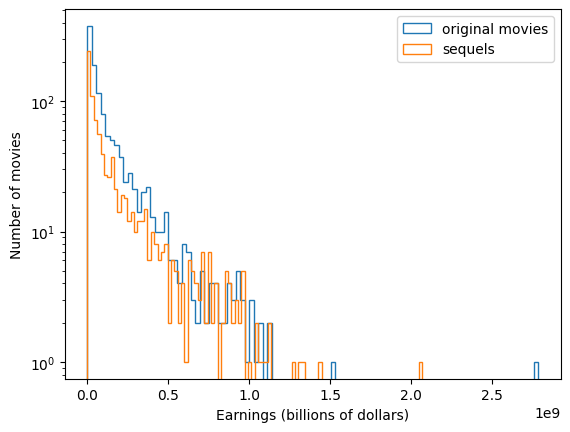

In [134]:
# Plot the earnings of original movies and sequels using a histogram with a logarithmic scale on the y-axis.
n_bins = 100
plt.hist(original_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='original movies')
plt.hist(sequels_earnings['BoxOffice'], bins=n_bins, log=True, histtype="step",  label='sequels')
plt.xlabel('Earnings (billions of dollars)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

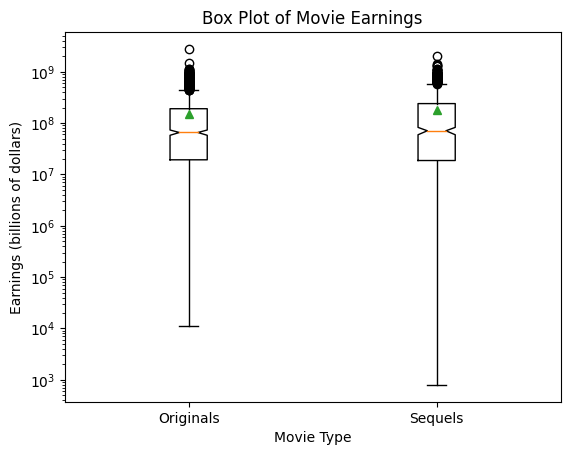

In [171]:
# For better vizualisation, we plot the Box Plot of earnings of original movies and sequels

# Combine the earnings data into a list for box plot creation
earnings_data = [original_earnings['BoxOffice'], sequels_earnings['BoxOffice']]

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Create the boxplot
bp = plt.boxplot(earnings_data, labels=['Originals', 'Sequels'], notch=True, showmeans=True)

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Earnings (billions of dollars)')
plt.title('Box Plot of Movie Earnings')

# (We don't use patch artist to have access to median values)
# Add colors to the box plots
#box_colors = ['blue', 'orange']
#for box, color in zip(plt.boxplot(earnings_data, labels=['Originals', 'Sequels'], notch=True, patch_artist=True, showmeans=True)['boxes'], box_colors):
    #box.set_facecolor(color)

# Show the plot
plt.show()

It is difficult to see if originals rake in more money than sequels. Let's explore the values.

In [175]:
bp.keys()
medians = [round(item.get_ydata()[0], 1) for item in bp['medians']]
means = [round(item.get_ydata()[0], 1) for item in bp['means']]
minimums = [round(item.get_ydata()[0], 1) for item in bp['caps']][::2]
maximums = [round(item.get_ydata()[0], 1) for item in bp['caps']][1::2]
q1 = [round(min(item.get_ydata()), 1) for item in bp['boxes']]
q3 = [round(max(item.get_ydata()), 1) for item in bp['boxes']]

stats = [medians, means, minimums, maximums, q1, q3]
stats_names = ['Median', 'Mean', 'Minimum', 'Maximum', 'Q1', 'Q3']
categories = ['Originals', 'Sequels'] # to be updated
for i in range(len(categories)):
    print(categories[i])
    for j in range(len(stats)):
        print(f'{stats_names[j]}: {stats[j][i]}')
    print('\n')

Originals
Median: 65589347.5
Mean: 150052106.2
Minimum: 11385.0
Maximum: 443140005.0
Q1: 19269246.2
Q3: 190460091.2


Sequels
Median: 70852036.5
Mean: 181637353.4
Minimum: 795.7
Maximum: 566652812.0
Q1: 18663083.0
Q3: 239712431.0




It seems that sequels rank more money than originals. But the datasets have missing values.

In [176]:
print(f'Percentage of originals that has the revenue in the dataset : {len(original_earnings)/ len(df_has_sequels):.2f}')
print(f'Percentage of movies with no sequels that has the revenue in the dataset : {len(sequels_earnings)/ len(df_sequels):.2f}')

Percentage of originals that has the revenue in the dataset : 0.31
Percentage of movies with no sequels that has the revenue in the dataset : 0.23


Only 31% and 23% of the data repespectively is present. We need a deeper analysis to see if originals tend to generate more money than sequels.

In [177]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(original_earnings['BoxOffice'], sequels_earnings['BoxOffice'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in earnings between original movies and their sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in earnings between original movies and their sequels.')


T-test Statistic: -2.9909767839184784
P-value: 0.0028195568380016316
Reject the null hypothesis: There is a significant difference in earnings between original movies and their sequels.


### Duration 

In [178]:
original_duration = df_has_sequels.dropna(subset=['Runtime'])
sequels_duration = df_sequels.dropna(subset=['Runtime'])

We take into account the outliers noticed in Part 1 and filter the movies.

In [179]:
filtered_original_duration = original_duration[(original_duration['Runtime'] >= 40) & (original_duration['Runtime'] < 300)]
filtered_sequels_duration = sequels_duration[(sequels_duration['Runtime'] >= 40) & (sequels_duration['Runtime'] < 300)]

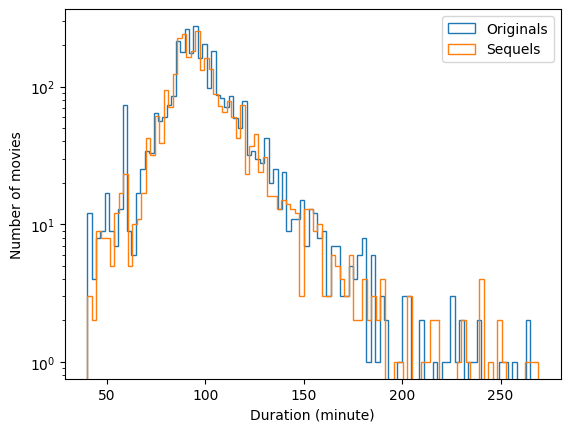

In [180]:
# Plot the duration of original movies and sequels using a histogram with a logarithmic scale on the y-axis.
n_bins = 100
plt.hist(filtered_original_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='Originals')
plt.hist(filtered_sequels_duration['Runtime'], bins=n_bins, log=True, histtype="step",  label='Sequels')
plt.xlabel('Duration (minute)')
plt.ylabel('Number of movies')
plt.legend(loc='best')
plt.show()

In [181]:
# Compute percentage of movies that fit into this new definition
print(f'Percentage of originals with length between 40 minutes and 300 minutes in the dataset : {len(filtered_original_duration)/ len(original_duration):.2f}')
print(f'Percentage of sequels with length between 40 minutes and 300 minutes in the dataset : {len(filtered_sequels_duration)/ len(sequels_duration):.2f}')

Percentage of originals with length between 40 minutes and 300 minutes in the dataset : 0.96
Percentage of sequels with length between 40 minutes and 300 minutes in the dataset : 0.95


We can see that after filtering "outliers" in both categories, we still get to keep 96% of original movies and 95% of sequels. Let's now plot the Box Plot to get a better grasp of the distribution of the duration of our filtered movies. 

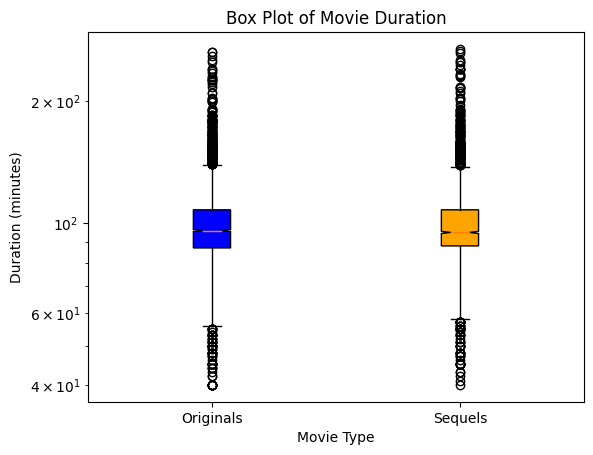

In [182]:
# Combine the duration data into a list for box plot creation
duration_data = [filtered_original_duration['Runtime'], filtered_sequels_duration['Runtime']]

# Set labels for the axes and a title for the plot
plt.xlabel('Movie Type')
plt.ylabel('Duration (minutes)')
plt.title('Box Plot of Movie Duration')

# Set the y-axis to a logarithmic scale
plt.yscale('log')

# Add colors to the box plots
box_colors = ['blue', 'orange']
for box, color in zip(plt.boxplot(duration_data, labels=['Originals', 'Sequels'], notch=True, patch_artist=True)['boxes'], box_colors):
    box.set_facecolor(color)

# Show the plot
plt.show()

Let's perform a t-test to see if there is a significant difference in the mean of the duration of feature films with sequels and feature films without sequels.

In [183]:
# Perform an independent two-sample t-test
t_stat, p_value = ttest_ind(filtered_original_duration['Runtime'], filtered_sequels_duration['Runtime'], equal_var=False)

# Print the results
print(f'T-test Statistic: {t_stat}')
print(f'P-value: {p_value}')

# Define the significance level
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value < alpha:
    print('Reject the null hypothesis: There is a significant difference in duration between originals and sequels.')
else:
    print('Fail to reject the null hypothesis: There is no significant difference in duration between originals and sequels.')


T-test Statistic: -0.27114988665623796
P-value: 0.7862847727475103
Fail to reject the null hypothesis: There is no significant difference in duration between originals and sequels.


### Movie genre

In [190]:
originals_genres = df_has_sequels.dropna(subset=['Genres'])
sequels_genres = df_sequels.dropna(subset=['Genres'])

We select a random movie to examine how the genres are distributed.

In [191]:
print(sequels_genres.iloc[42]['Genres'])
print(type(sequels_genres.iloc[42]['Genres']))

{"/m/01q03": "Cult", "/m/01j1n2": "Coming of age", "/m/01z4y": "Comedy", "/m/02b5_l": "Teen"}
<class 'str'>


Let's switch it for a more efficient representation, as we did in Part 1.

In [192]:
def parse_genres(genre_str):
    try:
        # Convert the string to a dictionary and write all the genres with lower cases
        genre_dict = json.loads(genre_str.lower())

        # Return the list of genre names
        return list(genre_dict.values())
    except json.JSONDecodeError:
        # In case of parsing error, return an empty list or some default value
        return []

# Update 'Genres' column to contain lists of genre names
originals_genres['Genres'] = originals_genres['Genres'].apply(parse_genres)
sequels_genres['Genres'] = sequels_genres['Genres'].apply(parse_genres)

We will now explore the top genres, because it seems that some genre names are different but with the same meaning.

In [195]:
# Count the frequency of each genre for movies with sequels
genre_freq_originals = originals_genres['Genres'].explode().value_counts()

# Count the frequency of each genre for movies without sequels
genre_freq_sequels = sequels_genres['Genres'].explode().value_counts()

# Print the top 20 genres for movies with and without sequels
#print(f'Top genres for originals: \n {genre_freq_originals.head(20)} \n')
print(f'Top genres for sequels: \n {genre_freq_sequels.head(20)}')

Top genres for sequels: 
 Genres
comedy               755
drama                650
action               637
thriller             549
adventure            493
horror               480
family film          453
action/adventure     410
animation            342
world cinema         318
science fiction      306
fantasy              302
crime fiction        294
japanese movies      236
romance film         220
children's/family    198
cult                 176
mystery              145
slasher              116
teen                 114
Name: count, dtype: int64


As in Part 1, we decide to create a list of 21 genres, containing the top 20 genres of originals and sequels.

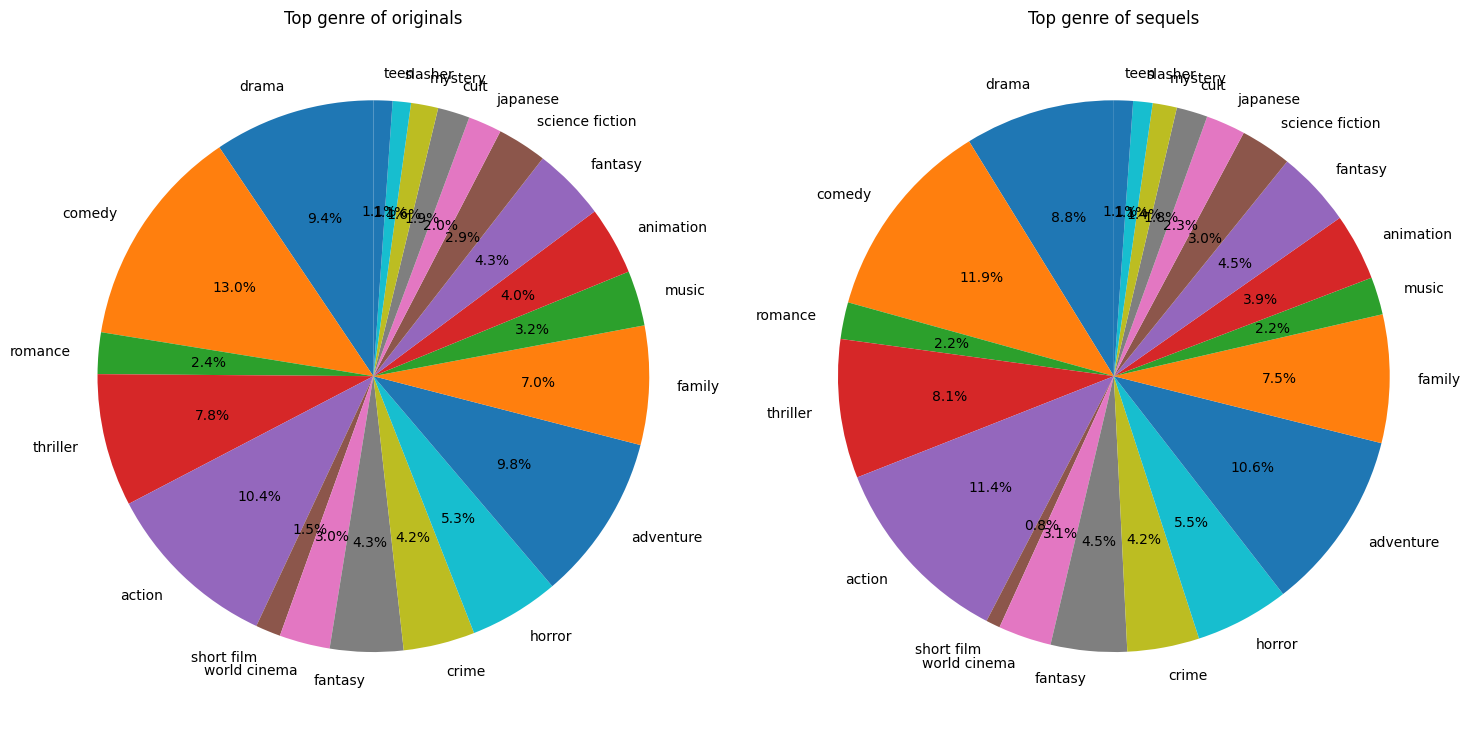

In [196]:
# List of the top genres
top_genres = ['drama', 'comedy', 'romance', 'thriller', 'action', 'short film', 'world cinema', 'fantasy', 'crime', 'horror', 'adventure', 'family', 'music', 
              'animation', 'fantasy', 'science fiction', 'japanese', 'cult', 'mystery', 'slasher', 'teen'] 

# Count the occurrences of each top genre
def count_top_genre(genre_freq_series, top_genre):
    return genre_freq_series[genre_freq_series.index.str.contains(top_genre, case=False)].sum()

# Get the frequency of each top genre
top_genres_freq_originals = [count_top_genre(genre_freq_originals, genre) for genre in top_genres]
top_genres_freq_sequels = [count_top_genre(genre_freq_sequels, genre) for genre in top_genres]

# Plot pie chart for movies with sequels
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.pie(top_genres_freq_originals, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of originals')

# Plot pie chart for movies with sequels
plt.subplot(1, 2, 2)
plt.pie(top_genres_freq_sequels, labels=top_genres, autopct='%1.1f%%', startangle=90)
plt.title('Top genre of sequels')

plt.tight_layout()
plt.show()

We do not see lots of differences between films with or without sequels. It seems quit normal as the genre of an original movie will not change in its sequels.

(MORE EXPLANATION)

Now we try to investiguate how the pairs of genre are linked, for example is the pair comedy/drama more present in movies with or without sequels? What kind of differences can we observed? To answer this question, let's create heatmaps to visualize the correlation between two genres.

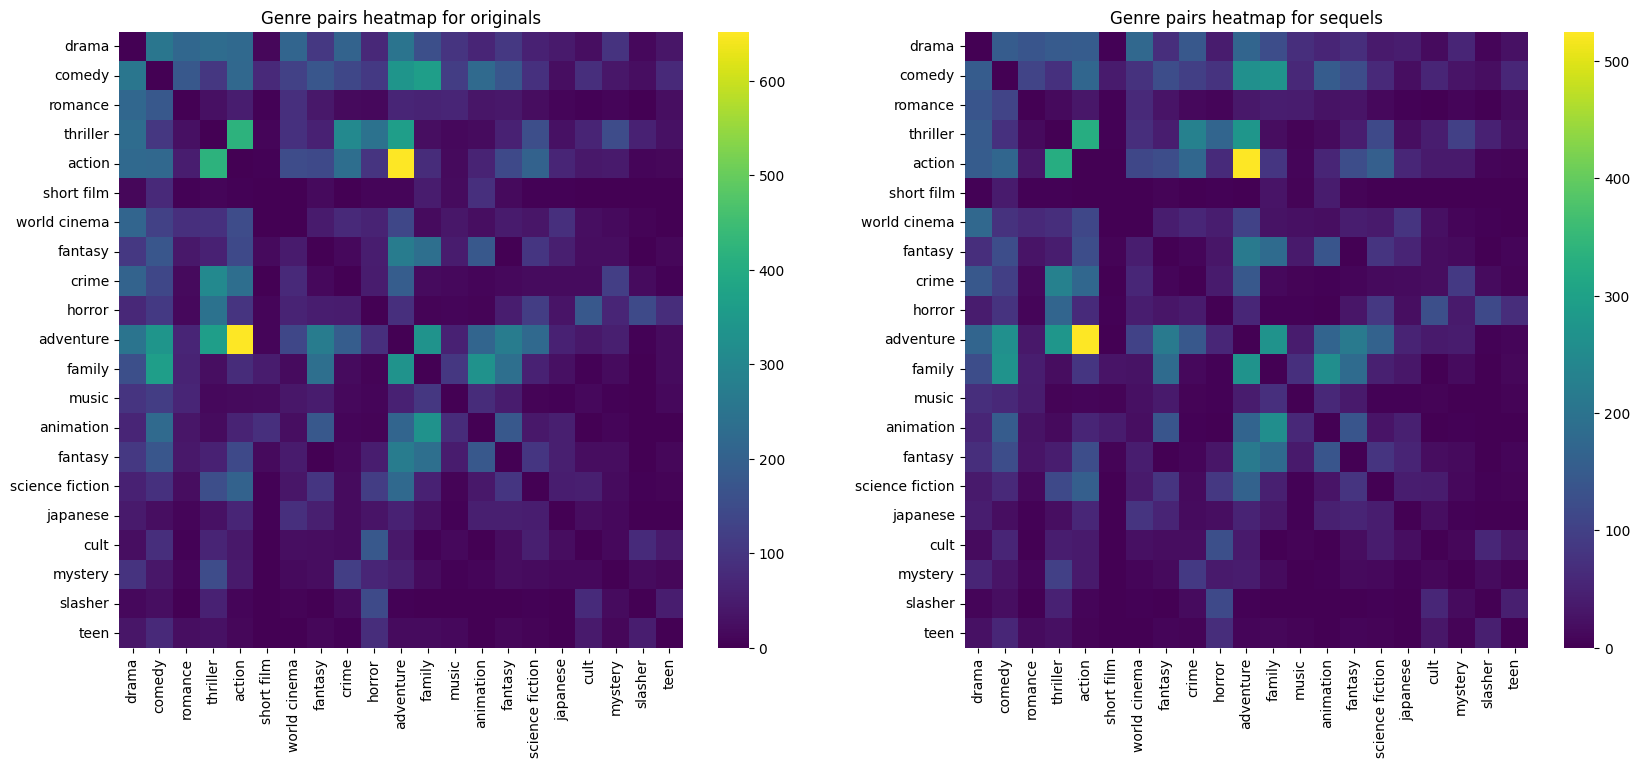

In [197]:
# Check if a pair of genres is present in a movie
def genre_pair_presence(genre_list, genre_pair):
    return all(any(genre in full_genre for full_genre in genre_list) for genre in genre_pair)

# Create a matrix for genre pairs for movie with and without sequels
genre_pair_matrix_originals = pd.DataFrame(index=top_genres, columns=top_genres, data=0)
genre_pair_matrix_sequels = pd.DataFrame(index=top_genres, columns=top_genres, data=0)

# Iterate through pairs of genres 
for genre1 in top_genres:
    for genre2 in top_genres:
        if genre1 != genre2:
            genre_pair = [genre1, genre2]
            
            # Check if the pair is present in each movie and count
            genre_pair_matrix_originals.at[genre1, genre2] = len(originals_genres[originals_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])
            genre_pair_matrix_sequels.at[genre1, genre2] = len(sequels_genres[sequels_genres['Genres'].apply(lambda x: genre_pair_presence(x, genre_pair))])

# Plot the heatmaps
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.heatmap(genre_pair_matrix_originals, cmap='viridis', fmt='d', ax=ax1)
sns.heatmap(genre_pair_matrix_sequels, cmap='viridis', fmt='d', ax=ax2)
ax1.set_title('Genre pairs heatmap for originals')
ax2.set_title('Genre pairs heatmap for sequels')
plt.show()

(EXPLANATION)